In [88]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression,RANSACRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_predict, StratifiedGroupKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.metrics import classification_report

from itertools import product

In [73]:

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import joblib

In [3]:
# Show all columns
pd.set_option("display.max_columns", None)

# Show all rows (optional — careful if you have many rows)
pd.set_option("display.max_rows", None)

# Wider display
pd.set_option("display.width", 200)

In [4]:
def sanitize_filename(name):
    # Replace any character not a-z, A-Z, 0-9, _ or - with _
    return re.sub(r'[^0-9a-zA-Z_\-]', '_', name)

def plot_predicted_vs_actual(y_true, y_pred, orig_capacity, title="Predicted vs Actual Sedimentation Rate", zoom=None):
    """
    Plots predicted vs actual sedimentation rate with 1:1 line, coloring points by reservoir capacity.
    
    Parameters
    ----------
    y_true : array-like
        Actual sedimentation rates
    y_pred : array-like
        Predicted sedimentation rates
    orig_capacity : array-like
        Original reservoir capacities (used for coloring)
    title : str
        Plot title
    zoom : float or None
        If provided, sets the max limit for x and y axes
    """
    plt.figure(figsize=(6,6))
    scatter = plt.scatter(
        y_true, y_pred, c=np.log10(orig_capacity), cmap="viridis", alpha=0.7, edgecolor="k"
    )
    
    # 1:1 reference line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="1:1 line")
    
    plt.xlabel("Actual Sedimentation Rate (MCM/year)")
    plt.ylabel("Predicted Sedimentation Rate (MCM/year)")
    if zoom:
        plt.xlim(right=zoom)
        plt.ylim(top=zoom)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # Colorbar for capacity
    cbar = plt.colorbar(scatter)
    cbar.set_label("Log10(Original Capacity (in MCM))")
    
    plt.show()

In [5]:
def plot_observed_vs_predicted(y_val_true, y_val_pred, y_test_true, y_test_pred,
                               val_label="Validation", test_label="Test",
                               figsize=(12,6), scatter_colors=("skyblue", "lightgreen"), zoom=20):
    """
    Plot observed vs predicted values for validation and test sets side by side,
    with 1:1 line and annotated MAE and R².
    
    Parameters
    ----------
    y_val_true : array-like
        True target values for validation set.
    y_val_pred : array-like
        Predicted target values for validation set.
    y_test_true : array-like
        True target values for test set.
    y_test_pred : array-like
        Predicted target values for test set.
    val_label : str
        Label for validation subplot.
    test_label : str
        Label for test subplot.
    figsize : tuple
        Figure size.
    scatter_colors : tuple
        Colors for validation and test scatter points.
    """
    
    val_mae = mean_absolute_error(y_val_true, y_val_pred)
    val_r2 = r2_score(y_val_true, y_val_pred)
    
    test_mae = mean_absolute_error(y_test_true, y_test_pred)
    test_r2 = r2_score(y_test_true, y_test_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Validation plot
    axes[0].scatter(y_val_true, y_val_pred, color=scatter_colors[0], alpha=0.7)
    min_val, max_val = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
    axes[0].set_xlabel("Observed")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title(f"{val_label} Set")
    axes[0].set_ylim(ymax=zoom)
    axes[0].set_xlim(xmax=zoom)
    axes[0].text(0.05, 0.95, f"Mean Absolute Error: {val_mae:.4f}\nR²: {val_r2:.4f}", 
                 transform=axes[0].transAxes, verticalalignment='top',
                 bbox=dict(facecolor='white', alpha=0.6))
    
    # Test plot
    axes[1].scatter(y_test_true, y_test_pred, color=scatter_colors[1], alpha=0.7)
    min_test, max_test = min(y_test_true.min(), y_test_pred.min()), max(y_test_true.max(), y_test_pred.max())
    axes[1].plot([min_test, max_test], [min_test, max_test], 'r--', linewidth=1)
    axes[1].set_xlabel("Observed")
    axes[1].set_ylabel("Predicted")
    axes[1].set_title(f"{test_label} Set")
    axes[1].set_ylim(ymax=zoom)
    axes[1].set_xlim(xmax=zoom)
    axes[1].text(0.05, 0.95, f"Mean Absolute Error: {test_mae:.4f}\nR²: {test_r2:.4f}", 
                 transform=axes[1].transAxes, verticalalignment='top',
                 bbox=dict(facecolor='white', alpha=0.6))
    
    plt.tight_layout()
    plt.show()

def plot_model_comparison_regression(clr_model_performance, colors, zoom=None, savepath=None):
    """
    Creates a 2x3 subplot grid comparing Validation (top) and Test (bottom) sets
    for different models, with MAE and R² annotated.

    Parameters
    ----------
    clr_model_performance : dict
        Example:
        {
            'CatBoost': {'validation': (y_val, y_pred_val),
                         'test': (y_test, y_pred_test)},
            'LightGBM': {...},
            'XGBoost': {...}
        }
    colors : dict
        Mapping of model names to colors.
    zoom : float or None
        If given, sets xlim and ylim to (0, zoom).
    """
    models = list(clr_model_performance.keys())
    sets = ["validation", "test"]

    fig, axes = plt.subplots(2, len(models), figsize=(15, 8), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.25, wspace=0.25)

    # Add section titles
    axes[0, len(models)//2].set_title("Validation Sets", fontsize=14, pad=20)
    axes[1, len(models)//2].set_title("Test Sets", fontsize=14, pad=20)

    handles = []
    labels = []

    for col, model in enumerate(models):
        for row, dataset in enumerate(sets):
            ax = axes[row, col]
            y_true, y_pred = clr_model_performance[model][dataset]

            # Scatter (with alpha < 1 in the plot)
            sc = ax.scatter(y_true, y_pred, alpha=0.6, s=30,
                            color=colors[model], label=model)

            # 1:1 line
            lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
            ax.plot(lims, lims, 'k--', lw=1.2, alpha=0.7, label="1:1 line")

            if zoom:
                ax.set_xlim(xmax= zoom)
                ax.set_ylim(ymax = zoom)

            # Metrics
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            ax.text(0.05, 0.95, f"Mean Absolute Error: {mae:.2f}\nR²: {r2:.2f}",
                    transform=ax.transAxes, fontsize=12,
                    verticalalignment="top",
                    bbox=dict(boxstyle="round,pad=0.3",
                              facecolor="white", alpha=0.6, edgecolor="none"))

            if row == 1:
                ax.set_xlabel("Observed")
            if col == 0:
                ax.set_ylabel("Predicted")

            # Collect proxy handles for legend only once per model
            if row == 0:
                proxy = Line2D([0], [0], marker='o', color='w',
                               markerfacecolor=colors[model],
                               markersize=10, alpha=1, label=model)
                handles.append(proxy)
                labels.append(model)

    # Proxy for 1:1 line
    line_proxy = Line2D([0], [0], color='k', linestyle='--', lw=1.2, alpha=0.7, label="1:1 line")
    handles.append(line_proxy)
    labels.append("1:1 line")

    # Legend (only proxies, with alpha=1 for markers)
    leg = fig.legend(handles, labels, loc='upper right',
                     bbox_to_anchor=(0.98, 0.96),
                     ncol=len(models)+1, frameon=False, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()

In [6]:
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, f1_score, mean_squared_error, r2_score,
    classification_report, precision_recall_fscore_support, accuracy_score
)
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE 
from collections import Counter
import optuna
import xgboost as xgb
import rioxarray as rxr

import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import Point, LineString
from scipy.stats import skew, kurtosis
from tqdm import tqdm

import plotly.express as px


import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# LightGBM & XGBoost
import lightgbm as lgb
from xgboost import XGBClassifier

In [7]:
df_path = '/tiger1/msanchit/research/sedimentation/data_analysis/grilss_features/Features_v1/GRILSS_extended_data_v1.1.xlsx'

In [8]:
df = pd.read_excel(df_path)

In [9]:
print(list(df.columns))

['GRILSS OID', 'GRILSS RID', 'Reservoir', 'Country', 'HYBAS_ID', 'Major River Basin', 'Continent', 'Sedimentation Amount (MT)', 'Sediment Bulk Density (ton/m^3)', 'Observed Duration (years)', 'Observation End Year', 'Observation Start Year', 'Built Year', 'Original Built Capacity (MCM)', 'Catchment Area (Km^2)', 'Height (m)', 'Latitude', 'Longitude', 'Survey Type', 'Type of Storage', 'Comments', 'Original Source URL', 'Fields Corrected', 'Fields Computed', 'GDAT Dam Name', 'GDAT Feature_ID', 'GRAND_ID', 'GRAND Wrong Location', 'GDAT Wrong Location', 'Dam Removed or Dried', 'Creek Dam', 'diff_CA_AreaKm2', 'mean_annual_inflow', 'peak_annual_inflow', 'artificial_surfaces_mean', 'cropland_mean', 'grassland_mean', 'tree_covered_mean', 'shrubs_covered_mean', 'aquatic_herbaceous_mean', 'mangroves_mean', 'sparse_vegetation_mean', 'bare_soil_mean', 'snow_glaciers_mean', 'waterbodies_mean', 'dominant_class_mode', 'COARSE_mean', 'SAND_mean', 'SILT_mean', 'CLAY_mean', 'BULK_mean', 'lu_change_freq_

In [10]:
cols_of_no_use = ['GRILSS OID', 'Reservoir','Major River Basin','Sediment Bulk Density (ton/m^3)',
                  'Comments', 'Original Source URL', 'Fields Corrected', 'Fields Computed', 'GDAT Dam Name', 
                  'GDAT Feature_ID', 'GRAND_ID', 'GRAND Wrong Location', 'GDAT Wrong Location']

In [11]:
df = df.drop(cols_of_no_use, axis=1)

#### Target Classification before treating missing values


Counts for 2_class:
clr_type_2_class
Non-Severe    1228
Severe         140
Name: count, dtype: int64

Counts for 3_class:
clr_type_3_class
Non-Severe    1017
High           211
Severe         140
Name: count, dtype: int64

Counts for 4_class:
clr_type_4_class
Low       716
Medium    301
High      211
Severe    140
Name: count, dtype: int64


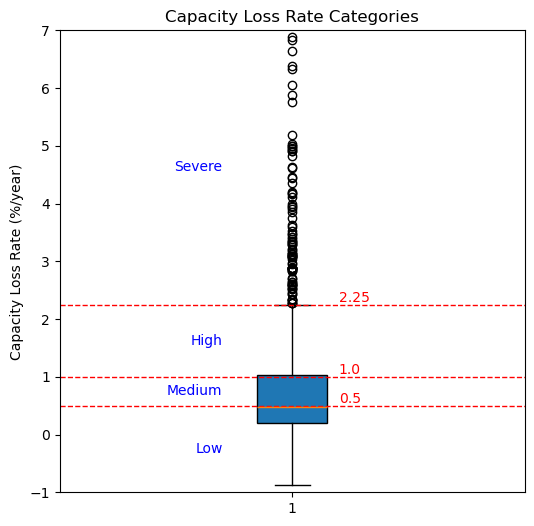

In [12]:
col = 'Capacity Loss Rate (%/year)'

# -----------------------------
# Define thresholds for 4, 3, 2 class
# -----------------------------
med_thr = 0.5
high_thr = 1.0
severe_thr = 2.25
thresholds_4_class = [-5, med_thr, high_thr, severe_thr, float('inf')]
thresholds__4_class_visual = [-1, med_thr, high_thr, severe_thr, 7]
labels_4_class = ['Low', 'Medium', 'High', 'Severe']

# 3-class: low+medium, high, severe
thresholds_3_class = [-5, high_thr, severe_thr, float('inf')]
labels_3_class = ['Non-Severe', 'High', 'Severe']

# 2-class: low+medium+high, severe
thresholds_2_class = [-5, severe_thr, float('inf')]
labels_2_class = ['Non-Severe', 'Severe']

# -----------------------------
# Classify data
# -----------------------------
df['clr_type_4_class'] = pd.cut(df[col], bins=thresholds_4_class, labels=labels_4_class, right=False)
df['clr_type_3_class'] = pd.cut(df[col], bins=thresholds_3_class, labels=labels_3_class, right=False)
df['clr_type_2_class'] = pd.cut(df[col], bins=thresholds_2_class, labels=labels_2_class, right=False)

# -----------------------------
# Count observations per category
# -----------------------------
for cls_type, labels in zip(['2_class','3_class','4_class'],
                            [labels_2_class, labels_3_class, labels_4_class]):
    print(f"\nCounts for {cls_type}:")
    print(df[f'clr_type_{cls_type}'].value_counts().reindex(labels))

# -----------------------------
# Create box plot for 4-class with threshold lines
# -----------------------------
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(df[col], vert=True, patch_artist=True, showfliers=True)

# Add threshold lines for 4-class
for t in thresholds_4_class[1:-1]:  # skip first and last
    ax.axhline(y=t, color='red', linestyle='--', linewidth=1)
    ax.text(1.10, t+0.12, f"{t}", color='red', va='center')
    
for label in labels_4_class:
    ax.text(0.85, (thresholds__4_class_visual[labels_4_class.index(label)] + thresholds__4_class_visual[labels_4_class.index(label)+1])/2,
            label, color='blue', va='center', ha='right', fontsize=10)
ax.set_ylim(-1, 7)
ax.set_ylabel(col)
ax.set_title("Capacity Loss Rate Categories")
plt.savefig('/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/T2_CLT_boxplot.png', dpi=300)
plt.show()

#### Treating Missing values

In [13]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]  # Only show columns with missing values
print(missing_counts)

Height (m)                         159
cv_annual_outflow                   66
mean_annual_outflow_std             66
SA_annual_mean_clip                 63
evaporation_annual_std              57
mean_annual_outflow                 56
aec_mean_slope                      56
evaporation_annual_mean             56
aec_concavity_index                 56
aec_mean_curvature                  56
NSSC_t_annual_std                   55
NSSC2_annual_mean                   53
NSSC2_t_annual_mean                 53
SA_annual_mean                      53
SA_annual_std                       53
NSSC_annual_std                     53
SA_kurtosis                         53
SA_cv                               53
NSSC_skewness                       53
NSSC_kurtosis                       53
NSSC_cv                             53
NSSC_annual_mean                    53
SA_skewness                         53
max_days_annual_SA_above_90         53
max_days_annual_NSSC2_above_90      53
max_annual_NSSC2_persiste

##### Handling Missing Height Values

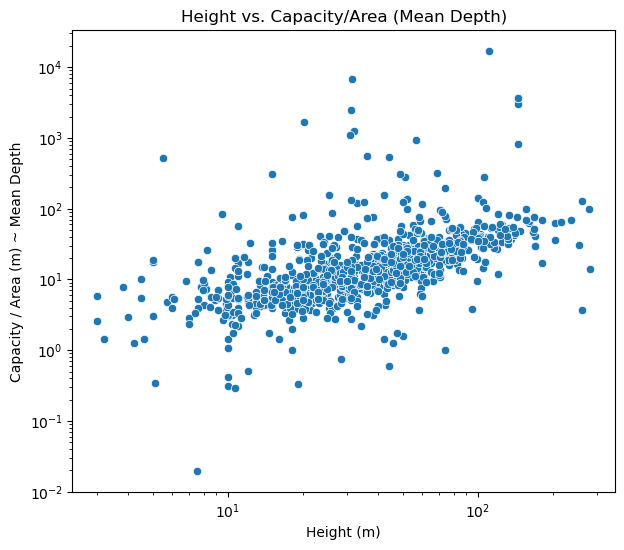

Correlation in log-log space: 0.608


In [14]:
# Compute Capacity/Area ratio (proxy for mean depth)
df["cap_area_ratio"] = df["Original Built Capacity (MCM)"] / df["area_km2"]

# Drop zeros or NaNs to avoid errors
plot_data = df.dropna(subset=["Height (m)", "cap_area_ratio"])
plot_data = plot_data[plot_data["cap_area_ratio"] > 0]

# Scatter plot
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=plot_data,
    x="Height (m)",
    y="cap_area_ratio"
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Height (m)")
plt.ylabel("Capacity / Area (m) ~ Mean Depth")
plt.title("Height vs. Capacity/Area (Mean Depth)")
plt.show()

# Correlation
corr_log = np.corrcoef(
    np.log10(plot_data["Height (m)"]),
    np.log10(plot_data["cap_area_ratio"])
)[0,1]
print(f"Correlation in log-log space: {corr_log:.3f}")

In [15]:
# Prepare data for regression (drop rows with missing values in either)
reg_data = df.dropna(subset=["Height (m)", "cap_area_ratio"])
X = np.log10(reg_data["cap_area_ratio"]).values.reshape(-1,1)
y = np.log10(reg_data["Height (m)"]).values

# Fit robust regression
ransac = RANSACRegressor(min_samples=10, random_state=20)
ransac.fit(X, y)


# Predict missing Height values
impute_mask = df["Height (m)"].isna() & df["cap_area_ratio"].notna()
if impute_mask.sum() > 0:
    predicted_height = 10**ransac.predict(
        np.log10(df.loc[impute_mask, "cap_area_ratio"]).values.reshape(-1,1)
    )
    
    # Clip predictions to min 5 m and max 120 m
    predicted_height = np.clip(predicted_height, 5, 120)
    
    df.loc[impute_mask, "Height (m)"] = predicted_height

# Create a flag column for imputed values
df["height_was_missing"] = 0
df.loc[impute_mask, "height_was_missing"] = 1

# Optional: for rows where cap_area_ratio is also missing, leave Height as NaN
remaining_missing = df["Height (m)"].isna().sum()
print(f"Remaining missing Height values (cap_area_ratio missing): {remaining_missing}")


Remaining missing Height values (cap_area_ratio missing): 43


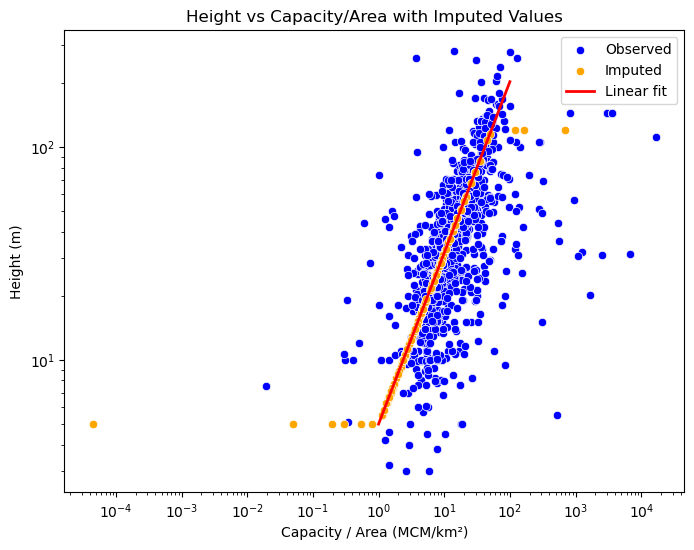

In [16]:
# Observed points
observed = df[df["height_was_missing"] == 0]

# Imputed points
imputed = df[df["height_was_missing"] == 1]

plt.figure(figsize=(8,6))

# Scatter plot for observed
sns.scatterplot(data=observed, x="cap_area_ratio", y="Height (m)", color="blue", label="Observed")

# Scatter plot for imputed
sns.scatterplot(data=imputed, x="cap_area_ratio", y="Height (m)", color="orange", label="Imputed")

# Optional: plot fitted regression line (for log-log fit)
import numpy as np
x_vals = np.linspace(1, 100, 100)
y_vals = 10**ransac.predict(np.log10(x_vals).reshape(-1,1))
plt.plot(x_vals, y_vals, color="red", label="Linear fit", linewidth=2)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Capacity / Area (MCM/km²)")
plt.ylabel("Height (m)")
plt.title("Height vs Capacity/Area with Imputed Values")
plt.legend()
plt.show()

Fitted Equations:
log10(HGT) = 0.70 + 0.80 * log10(Cap/Area)
HGT = 4.99 * (Cap/Area^0.80)


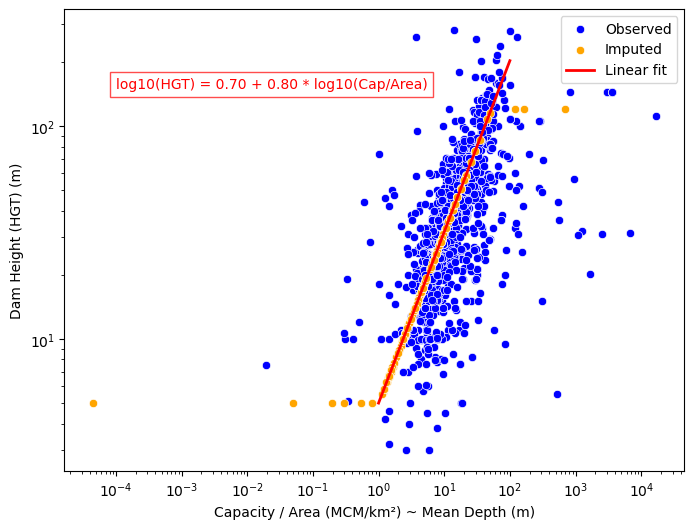

In [17]:
# Observed points
observed = df[df["height_was_missing"] == 0]

# Imputed points
imputed = df[df["height_was_missing"] == 1]

plt.figure(figsize=(8,6))

# Scatter plot for observed
sns.scatterplot(data=observed, x="cap_area_ratio", y="Height (m)", 
                color="blue", label="Observed")

# Scatter plot for imputed
sns.scatterplot(data=imputed, x="cap_area_ratio", y="Height (m)", 
                color="orange", label="Imputed")

# Extract coefficients from RANSAC
coef = ransac.estimator_.coef_[0]
intercept = ransac.estimator_.intercept_

# Log-log equation
log_eq = f"log10(HGT) = {intercept:.2f} + {coef:.2f} * log10(Cap/Area)"

# Power-law equation
A = 10**intercept
power_eq = f"HGT = {A:.2f} * (Cap/Area^{coef:.2f})"

# Print equations in console
print("Fitted Equations:")
print(log_eq)
print(power_eq)

# Plot fitted regression line
x_vals = np.linspace(1, 100, 100)
y_vals = 10**ransac.predict(np.log10(x_vals).reshape(-1,1))
plt.plot(x_vals, y_vals, color="red", label="Linear fit", linewidth=2)

# Annotate equation on the plot
plt.text(0.0001, 150, log_eq, fontsize=10, color="red",
         bbox=dict(facecolor="white", alpha=0.7, edgecolor="red"))

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Capacity / Area (MCM/km²) ~ Mean Depth (m)")
plt.ylabel("Dam Height (HGT) (m)")
# plt.title("Imputation of missing Height Values")
plt.legend()
plt.savefig('/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/missing_height_imputation.png', dpi=300)
plt.show()

In [18]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]  # Only show columns with missing values
print(missing_counts)

cv_annual_outflow                  66
mean_annual_outflow_std            66
SA_annual_mean_clip                63
evaporation_annual_std             57
mean_annual_outflow                56
aec_mean_curvature                 56
aec_concavity_index                56
aec_mean_slope                     56
evaporation_annual_mean            56
NSSC_t_annual_std                  55
max_annual_NSSC2_persistence       53
SA_annual_mean                     53
NSSC2_t_annual_mean                53
max_days_annual_SA_above_90        53
NSSC2_annual_mean                  53
NSSC_annual_std                    53
SA_annual_std                      53
SA_cv                              53
NSSC_skewness                      53
SA_kurtosis                        53
NSSC_kurtosis                      53
NSSC_cv                            53
NSSC_annual_mean                   53
SA_skewness                        53
max_days_annual_NSSC2_above_90     53
cap_area_ratio                     52
flow_length_

#### Dropping rows with missing values more than or equal to 25

In [19]:
# Get rows with at least one missing value
rows_with_missing = df[df.isnull().any(axis=1)]

# For each row, find the columns with NaNs
missing_columns_per_row = rows_with_missing.apply(lambda x: list(x.index[x.isnull()]), axis=1)

# Combine with index so you know which row has which missing cols
missing_df = pd.DataFrame({
    "RowIndex": rows_with_missing.index,
    "MissingColumns": missing_columns_per_row})
missing_df["MissNo"] = missing_df["MissingColumns"].str.len()
missing_df = missing_df.sort_values('MissNo',ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_df)

      RowIndex                                     MissingColumns  MissNo
1229      1229  [mean_annual_inflow, peak_annual_inflow, mean_...      42
1299      1299  [Height (m), length_km, area_km2, flow_length_...      30
1303      1303  [Height (m), length_km, area_km2, flow_length_...      30
1302      1302  [Height (m), length_km, area_km2, flow_length_...      30
1305      1305  [Height (m), length_km, area_km2, flow_length_...      30
1176      1176  [Height (m), length_km, area_km2, flow_length_...      30
1177      1177  [Height (m), length_km, area_km2, flow_length_...      30
1178      1178  [Height (m), length_km, area_km2, flow_length_...      30
1249      1249  [Height (m), length_km, area_km2, flow_length_...      30
1254      1254  [Height (m), length_km, area_km2, flow_length_...      30
1260      1260  [Height (m), length_km, area_km2, flow_length_...      30
1304      1304  [Height (m), length_km, area_km2, flow_length_...      30
1290      1290  [Height (m), length_km

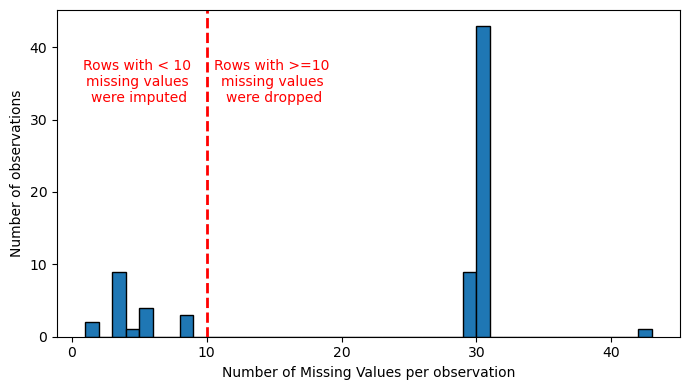

In [20]:
plt.figure(figsize=(7,4))
plt.hist(missing_df["MissNo"], bins=range(1, missing_df["MissNo"].max()+2), edgecolor='black')
plt.xlabel("Number of Missing Values per observation")
plt.ylabel("Number of observations")

# Add vertical dashed line at x=10
plt.axvline(10, color='red', linestyle='--', linewidth=2)

# Add annotations
plt.text(5, plt.ylim()[1]*0.85, "Rows with < 10 \nmissing values \nwere imputed", color='red', ha='center', va='top', fontsize=10)
plt.text(15, plt.ylim()[1]*0.85, "Rows with >=10 \nmissing values \nwere dropped", color='red', ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/missing_values_per_row_hist.png', dpi=300)
plt.show()

In [21]:
df.shape

(1368, 100)

In [22]:
# Drop rows with missing values greater than or equal to 10
df = df[df.isnull().sum(axis=1) < 10]

In [23]:
df.shape

(1315, 100)

In [24]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]  # Only show columns with missing values
print(missing_counts)

cv_annual_outflow                 13
mean_annual_outflow_std           13
SA_annual_mean_clip               10
evaporation_annual_std             4
lu_change_freq_percent_above_5     4
vegetation_loss_frequency_mean     4
vegetation_gain_frequency_mean     4
lu_change_freq_std                 4
lu_change_freq_mean                4
mean_annual_outflow                3
aec_mean_curvature                 3
aec_concavity_index                3
aec_mean_slope                     3
evaporation_annual_mean            3
NSSC_t_annual_std                  2
dtype: int64


#### Replacing infinite values ith NAN

In [25]:
# Force 'dominant_class_mode' to be categorical
categorical_columns = ['dominant_class_mode']

# Separate numeric and categorical
num_cols = df.select_dtypes(include=['number']).columns.difference(categorical_columns)
cat_cols = df.select_dtypes(exclude=['number']).columns.union(categorical_columns)

# Count infinities per numeric column
inf_counts = df[num_cols].apply(lambda x: np.isinf(x).sum())

# Show only columns with infinities
print(inf_counts[inf_counts > 0])

evaporation_annual_mean    6
dtype: int64


#### Imputing missing values for numerical columns using KNN

In [26]:
# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# KNN for numeric
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
df[num_cols] = knn_imputer.fit_transform(df[num_cols])

# --- KNN-based mode imputation for categorical columns ---
k = 5  # number of neighbors
numeric_data = df[num_cols].values

for col in cat_cols:
    missing_idx = np.where(df[col].isna())[0]
    
    for idx in missing_idx:
        # Compute Euclidean distance to all non-missing rows
        row = numeric_data[idx].reshape(1, -1)
        valid_idx = np.where(df[col].notna())[0]
        distances = np.linalg.norm(numeric_data[valid_idx] - row, axis=1)
        
        # Take k nearest neighbors
        nearest_idx = valid_idx[np.argsort(distances)[:k]]
        nearest_values = df.iloc[nearest_idx][col]
        
        # Fill missing with mode of nearest neighbors
        df.at[idx, col] = stats.mode(nearest_values).mode[0]

In [27]:

print(df.isna().sum().sum())  # should be 0 if everything imputed

0


All missing values and large values like infinity are now handled. 

In [28]:
print( "Number of Reservoirs:", df['GRILSS RID'].nunique() ) 

Number of Reservoirs: 984


#### Exploratory Data Analysis

In [29]:
# Basic info
print(df.shape)   # rows, cols
print(df.dtypes)  # datatypes of each column
print(df.isna().sum())  # missing values

# Quick stats
df.describe(include="all").transpose()

(1315, 100)
GRILSS RID                          float64
Country                              object
HYBAS_ID                            float64
Continent                            object
Sedimentation Amount (MT)           float64
Observed Duration (years)           float64
Observation End Year                float64
Observation Start Year              float64
Built Year                          float64
Original Built Capacity (MCM)       float64
Catchment Area (Km^2)               float64
Height (m)                          float64
Latitude                            float64
Longitude                           float64
Survey Type                          object
Type of Storage                      object
Dam Removed or Dried                float64
Creek Dam                           float64
diff_CA_AreaKm2                     float64
mean_annual_inflow                  float64
peak_annual_inflow                  float64
artificial_surfaces_mean            float64
cropland_mean       

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
GRILSS RID,1315.0,NaN,NaN,NaN,460.315589,272.672453,1.0,237.0,416.0,674.5,1013.0
Country,1315,54,India,663,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HYBAS_ID,1315.0,NaN,NaN,NaN,3531168026.205323,1601644833.012633,1030008110.0,2030026030.0,4030025460.0,4030031750.0,7030073620.0
Continent,1315,6,Asia,821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sedimentation Amount (MT),1315.0,NaN,NaN,NaN,4.770253,14.516248,-7.17,0.03,0.26,1.9,200.0
Observed Duration (years),1315.0,NaN,NaN,NaN,32.260837,25.274829,1.0,13.0,29.0,44.0,296.0
Observation End Year,1315.0,NaN,NaN,NaN,2001.003802,14.651948,1885.0,1990.0,2003.0,2013.0,2023.0
Observation Start Year,1315.0,NaN,NaN,NaN,1969.38403,24.624348,1713.0,1958.0,1972.0,1985.0,2019.0
Built Year,1315.0,NaN,NaN,NaN,1967.273764,24.375198,1713.0,1957.0,1968.0,1984.0,2018.0
Original Built Capacity (MCM),1315.0,NaN,NaN,NaN,1195.458101,5187.012094,0.000148,10.0,71.46,526.8,162000.0


In [30]:
print(df.dtypes.value_counts())

float64     92
object       4
int64        1
category     1
category     1
category     1
Name: count, dtype: int64


##### Univariate Analysis

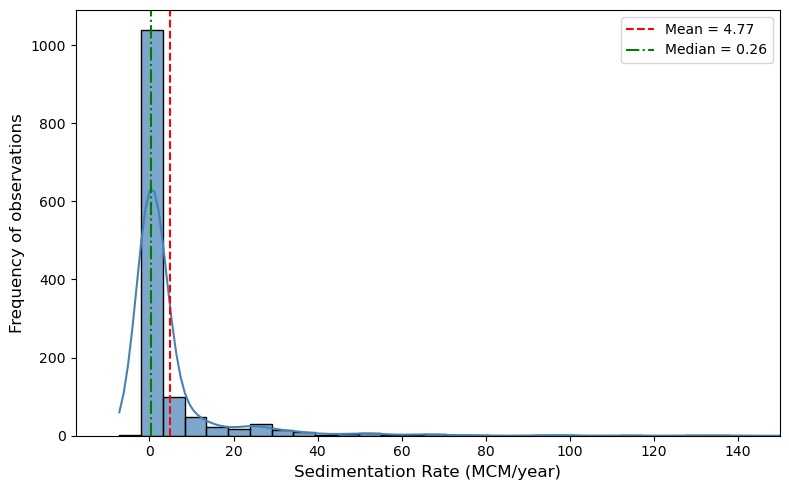

In [31]:
col = "Sedimentation Rate (MCM/year)"

plt.figure(figsize=(8, 5))
sns.histplot(df[col], bins=40, kde=True, color="steelblue", edgecolor="black", alpha=0.7)

# Add labels and title
plt.xlabel("Sedimentation Rate (MCM/year)", fontsize=12)
plt.ylabel("Frequency of observations", fontsize=12)
# plt.title("Distribution of Sedimentation Rate", fontsize=14, pad=15)

# Show mean and median lines
mean_val = df[col].mean()
median_val = df[col].median()
plt.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=1.5, label=f"Median = {median_val:.2f}")

plt.xlim(xmax=150)
plt.legend()
plt.tight_layout()
plt.savefig('/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/SR_hist.png', dpi=300)
plt.show()

##### Chi Squared test for Categorical Variables

In [30]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.append('HYBAS_ID')
cat_cols.append('dominant_class_mode')
for col in cat_cols:
    if col != 'clr_type_4_class':
        ct = pd.crosstab(df[col], df['clr_type_4_class'])
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        print(f"{col}: chi2={chi2:.2f}, p-value={p:.4f}")

Country: chi2=489.90, p-value=0.0000
Continent: chi2=109.64, p-value=0.0000
Survey Type: chi2=24.68, p-value=0.0034
Type of Storage: chi2=15.68, p-value=0.0013
clr_type_3_class: chi2=2630.00, p-value=0.0000
clr_type_2_class: chi2=1315.00, p-value=0.0000
HYBAS_ID: chi2=541.85, p-value=0.0000
dominant_class_mode: chi2=51.91, p-value=0.0008


##### Feature Transformation

In [32]:
df["log_catchment_area"] = np.log(df["Catchment Area (Km^2)"].clip(lower=1e-6))
df['log_diff_catchment_area'] = np.log(df['diff_CA_AreaKm2']).clip(lower=1e-6)
df["log_original_cap"] = np.log(df["Original Built Capacity (MCM)"].clip(lower=1e-6))
df['log_height'] = np.log(df['Height (m)'].clip(lower=1e-6))
df['log_area_km2'] = np.log(df['area_km2'].clip(lower=1e-6))
df['log_length_km'] = np.log(df['length_km'].clip(lower=1e-6))
df['log_flow_length_km'] = np.log(df['flow_length_km'].clip(lower=1e-6))
df["log_SA_annual_mean"] = np.log(df["SA_annual_mean"].clip(lower=1e-6))
df['log_SA_annual_mean_clip'] = np.log(df['SA_annual_mean_clip'].clip(lower=1e-6))
df['log_SA_annual_std'] = np.log(df['SA_annual_std'].clip(lower=1e-6))
df['log_SA_kurtosis'] = np.log(df['SA_kurtosis'].clip(lower=1e-6))
df['log_peak_annual_inflow'] = np.log(df['peak_annual_inflow'].clip(lower=1e-6))
df['log_mean_annual_inflow'] = np.log(df['mean_annual_inflow'].clip(lower=1e-6))
df['log_mean_annual_outflow'] = np.log(df['mean_annual_outflow'].clip(lower=1e-6))
df['log_mean_annual_inflow_std'] = np.log(df['mean_annual_inflow_std'].clip(lower=1e-6))
df['log_mean_annual_outflow_std'] = np.log(df['mean_annual_outflow_std'].clip(lower=1e-6))
df['log_annual_rainfall_mm'] = np.log(df['annual_rainfall_mm'].clip(lower=1e-6))

/tmp/ipykernel_628064/1968218405.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['log_flow_length_km'] = np.log(df['flow_length_km'].clip(lower=1e-6))
/tmp/ipykernel_628064/1968218405.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["log_SA_annual_mean"] = np.log(df["SA_annual_mean"].clip(lower=1e-6))
/tmp/ipykernel_628064/1968218405.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [33]:
inflow_cap_ratio = (df['mean_annual_inflow'] * 3600 * 24 * 365.25 / 1e6) / df['Original Built Capacity (MCM)'] # in 1/year
# Dictionary of engineered features
feature_dict = {
    "age_at_observation_end": df["Observation End Year"] - df["Built Year"],
    "relative_original_capacity": df["log_original_cap"] - df["log_catchment_area"],
    "net_vegetation_gain_frequency_mean": df["vegetation_gain_frequency_mean"] - df["vegetation_loss_frequency_mean"],

    "geometry_complexity": df["area_km2"] / (df["length_km"]**2),
    "rainfall_per_unit_area": np.where(
                            df["Catchment Area (Km^2)"] != 0,
                            df["annual_rainfall_mm"] / df["Catchment Area (Km^2)"],
                            df["annual_rainfall_mm"]
                        ),  

    "ratio_tree_bare_soil": np.where(
                            df["bare_soil_mean"] != 0,
                            df["tree_covered_mean"] / df["bare_soil_mean"],
                            df["tree_covered_mean"]
                        ),

    "ratio_shrubs_bare_soil": np.where(
                            df["bare_soil_mean"] != 0,
                            df["shrubs_covered_mean"] / df["bare_soil_mean"],
                            df["shrubs_covered_mean"] 
                        ),

    "ratio_coarse_to_sand": df["COARSE_mean"] / df["SAND_mean"],

    "residence_time": df["log_original_cap"] + np.log(1e6) - df["log_mean_annual_inflow"] - np.log(3600 * 24 * 365.25),
    "trapping_efficiency": np.exp(-0.0079 * (inflow_cap_ratio )) * 100,

    "estimated_clr": (np.exp(-0.0079 * (inflow_cap_ratio )) * 100)
                     * df["NSSC2_annual_mean"] * inflow_cap_ratio ,    # in %/year
    
    "estimated_sr": (np.exp(-0.0079 * (inflow_cap_ratio )) * 100)
                     * df["NSSC2_annual_mean"] * inflow_cap_ratio 
                     * df["Original Built Capacity (MCM)"] / 100,  # in MCM/year

    "relative_SA_mean_annual": df["log_SA_annual_mean_clip"] - df["log_area_km2"],
    "SA_mean_annual_to_capacity": df["log_SA_annual_mean_clip"] - df["log_original_cap"],

    "sediment_influx": df["mean_annual_inflow"] * df["NSSC2_annual_mean"],
    "sediment_outflux": df["mean_annual_outflow"] * df["NSSC2_annual_mean"],
}

# Convert dict to DataFrame and concat
engineered_features = pd.DataFrame(feature_dict)

#Drop overlapping columns from df before concatenation
df = df.drop(columns=engineered_features.columns.intersection(df.columns))

# Concatenate with engineered features
df = pd.concat([df, engineered_features], axis=1)

In [34]:
df['rainfall_per_unit_area'] = np.log(df['rainfall_per_unit_area'].clip(lower=1e-10))
df['geometry_complexity'] = np.log(df['geometry_complexity'].clip(lower=1e-6))
df['trapping_efficiency'] = np.log(df['trapping_efficiency'].clip(lower=1e-6))
df['estimated_clr'] = np.log(df['estimated_clr'].clip(lower=1e-15))
df['sediment_influx'] = np.log(df['sediment_influx'].clip(lower=1e-15))
df['sediment_outflux'] = np.log(df['sediment_outflux'].clip(lower=1e-15))

df["artificial_log_catchment_area"] = df["log_catchment_area"] + np.log(df["artificial_surfaces_mean"].clip(lower=1e-6)) - np.log(100)
df["cropland_log_catchment_area"] = df["log_catchment_area"] + np.log(df["cropland_mean"].clip(lower=1e-6)) - np.log(100)
df["grassland_log_catchment_area"] = df["log_catchment_area"] + np.log(df["grassland_mean"].clip(lower=1e-6)) - np.log(100)
df["tree_covered_log_catchment_area"] = df["log_catchment_area"] + np.log(df["tree_covered_mean"].clip(lower=1e-6)) - np.log(100)
df["shrubs_covered_log_catchment_area"] = df["log_catchment_area"] + np.log(df["shrubs_covered_mean"].clip(lower=1e-6)) - np.log(100)
df["aquatic_herbaceous_log_catchment_area"] = df["log_catchment_area"] + np.log(df["aquatic_herbaceous_mean"].clip(lower=1e-6)) - np.log(100)
df['mangroves_log_catchment_area'] = df["log_catchment_area"] + np.log(df["mangroves_mean"].clip(lower=1e-6)) - np.log(100)
df["sparse_vegetation_log_catchment_area"] = df["log_catchment_area"] + np.log(df["sparse_vegetation_mean"].clip(lower=1e-6)) - np.log(100)
df["bare_soil_log_catchment_area"] = df["log_catchment_area"] + np.log(df["bare_soil_mean"].clip(lower=1e-6)) - np.log(100)
df["snow_glaciers_log_catchment_area"] = df["log_catchment_area"] + np.log(df["snow_glaciers_mean"].clip(lower=1e-6)) - np.log(100)
df["waterbodies_log_catchment_area"] = df["log_catchment_area"] + np.log(df["waterbodies_mean"].clip(lower=1e-6)) - np.log(100)

In [35]:
df.shape

(1315, 144)

/tmp/ipykernel_279255/3961005735.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(np.arange(0,250000,25000), rotation=45)


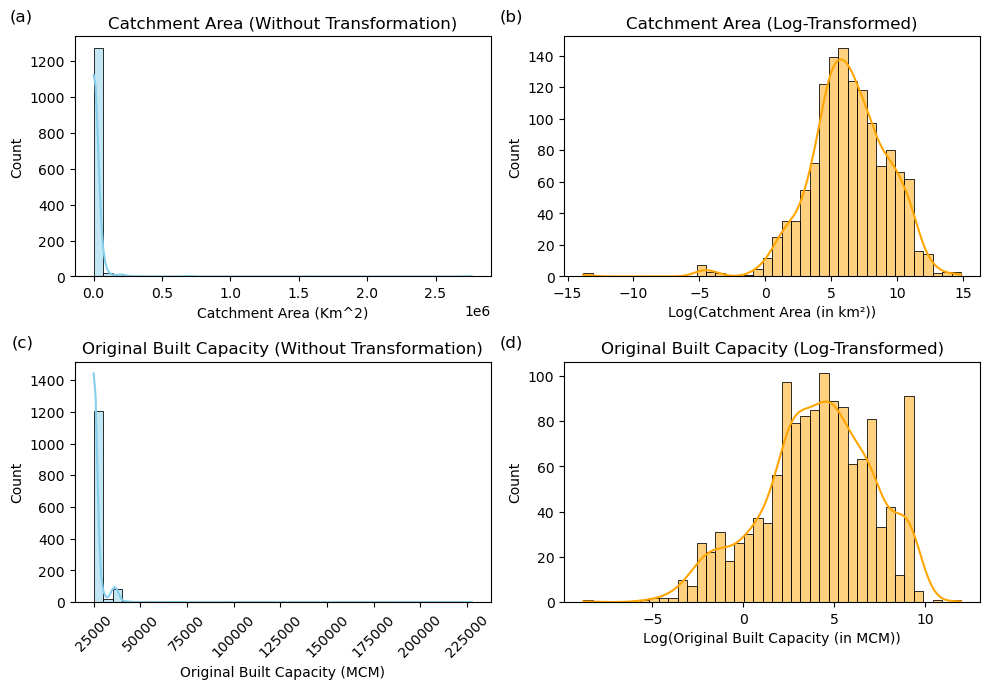

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10,7))

# Catchment Area (Original)
sns.histplot(df["Catchment Area (Km^2)"], bins=40, kde=True, ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Catchment Area (Without Transformation)")

# Catchment Area (Log)
sns.histplot(df["log_catchment_area"], bins=40, kde=True, ax=axes[0,1], color="orange")
axes[0,1].set_title("Catchment Area (Log-Transformed)")
axes[0,1].set_xlabel("Log(Catchment Area (in km²))")

# Built Capacity (Original)
sns.histplot(df["Original Built Capacity (MCM)"], bins=40, kde=True, ax=axes[1,0], color="skyblue")
axes[1,0].set_title("Original Built Capacity (Without Transformation)")
axes[1,0].set_xticklabels(np.arange(0,250000,25000), rotation=45)

# Built Capacity (Log)
sns.histplot(df["log_original_cap"], bins=40, kde=True, ax=axes[1,1], color="orange")
axes[1,1].set_title("Original Built Capacity (Log-Transformed)")
axes[1,1].set_xlabel("Log(Original Built Capacity (in MCM))")

# Add panel labels
labels = ["(a)", "(b)", "(c)", "(d)"]
positions = [(0,0), (0,1), (1,0), (1,1)]

for label, (i,j) in zip(labels, positions):
    axes[i,j].text(
        -0.1, 1.05, label, 
        transform=axes[i,j].transAxes, 
        fontsize=12, fontweight="medium", va="bottom", ha="right"
    )

plt.tight_layout()
plt.savefig('/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/log_transformations_example.png', dpi=300)
plt.show()

##### Further EDA

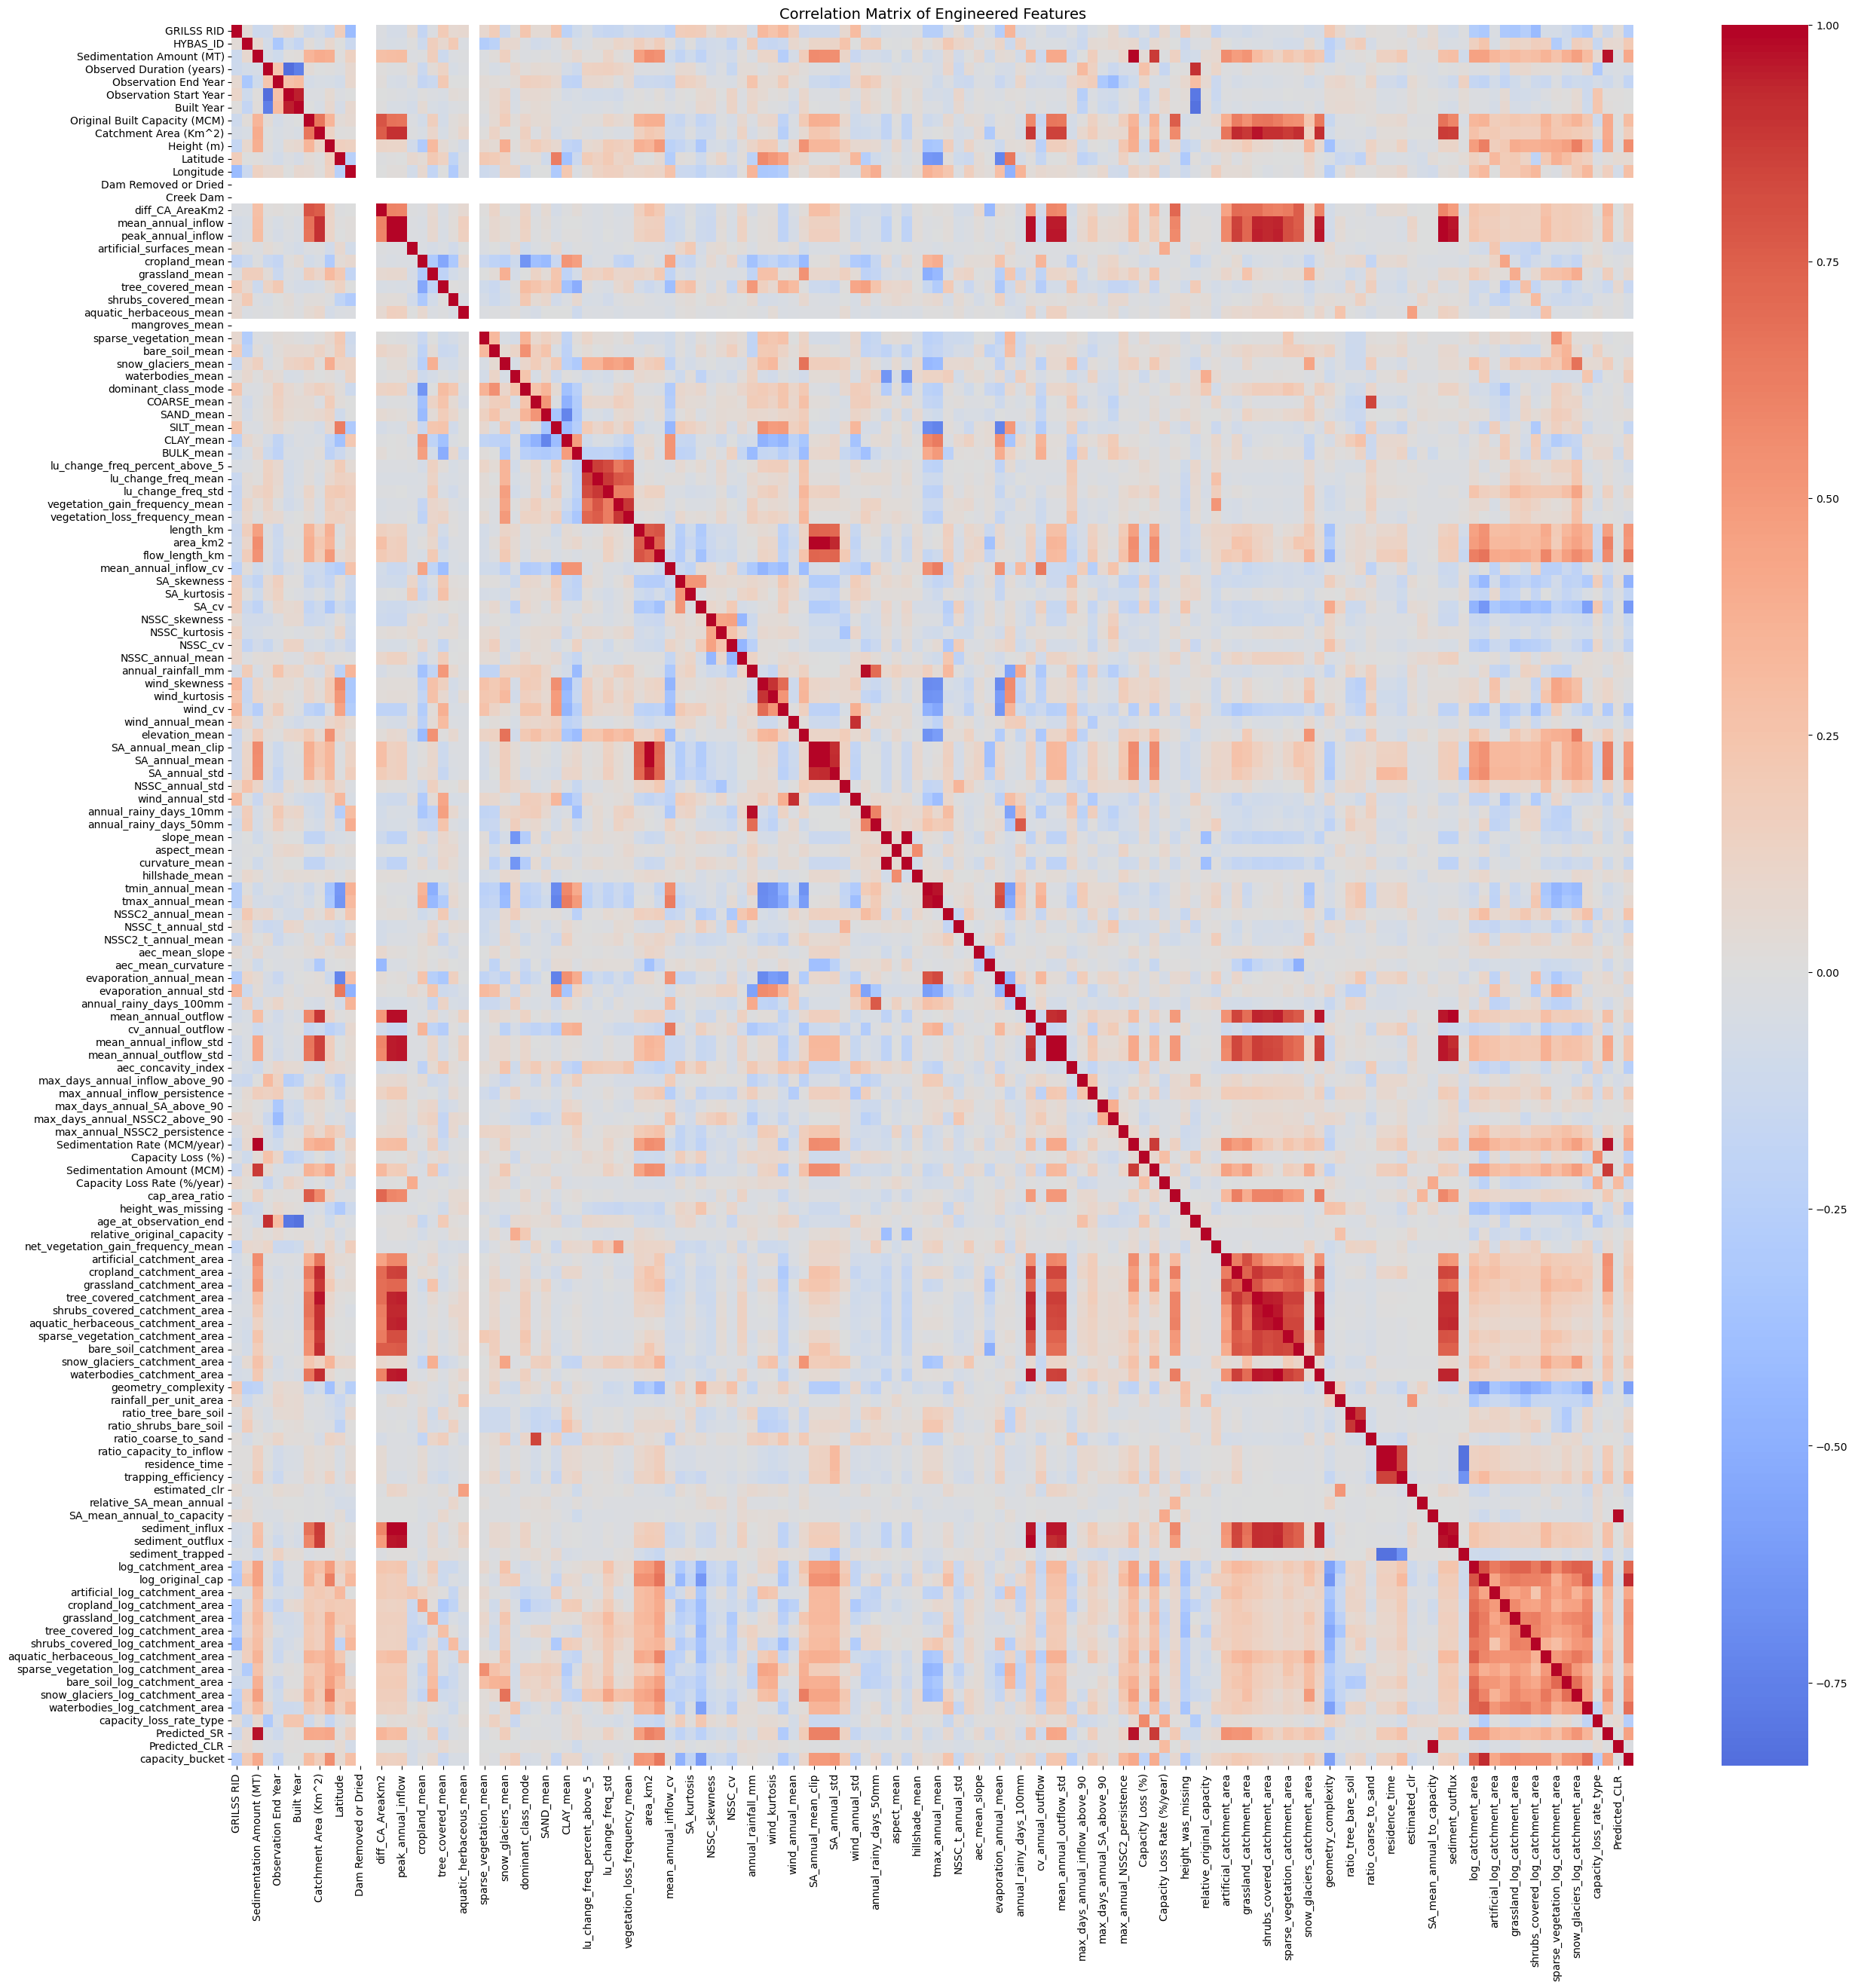

In [360]:
corr = df.corr(numeric_only=True)   # compute correlations (ignoring non-numeric)

plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Engineered Features", fontsize=14)
plt.show()

#### Feature Selection

In [36]:
print(df.columns.tolist())

['GRILSS RID', 'Country', 'HYBAS_ID', 'Continent', 'Sedimentation Amount (MT)', 'Observed Duration (years)', 'Observation End Year', 'Observation Start Year', 'Built Year', 'Original Built Capacity (MCM)', 'Catchment Area (Km^2)', 'Height (m)', 'Latitude', 'Longitude', 'Survey Type', 'Type of Storage', 'Dam Removed or Dried', 'Creek Dam', 'diff_CA_AreaKm2', 'mean_annual_inflow', 'peak_annual_inflow', 'artificial_surfaces_mean', 'cropland_mean', 'grassland_mean', 'tree_covered_mean', 'shrubs_covered_mean', 'aquatic_herbaceous_mean', 'mangroves_mean', 'sparse_vegetation_mean', 'bare_soil_mean', 'snow_glaciers_mean', 'waterbodies_mean', 'dominant_class_mode', 'COARSE_mean', 'SAND_mean', 'SILT_mean', 'CLAY_mean', 'BULK_mean', 'lu_change_freq_percent_above_5', 'lu_change_freq_mean', 'lu_change_freq_std', 'vegetation_gain_frequency_mean', 'vegetation_loss_frequency_mean', 'length_km', 'area_km2', 'flow_length_km', 'mean_annual_inflow_cv', 'SA_skewness', 'SA_kurtosis', 'SA_cv', 'NSSC_skewness

In [37]:
## Please maintain this order of features to produce the same results
num_features = [
     'log_original_cap', 'log_height', 'Latitude', 'Longitude',
     'log_area_km2', 'log_length_km', 'log_flow_length_km',
     'log_catchment_area', 'log_diff_catchment_area',
     
     'aec_mean_slope', 'aec_mean_curvature','aec_concavity_index',
     
     'artificial_log_catchment_area', 'cropland_log_catchment_area',
     'grassland_log_catchment_area', 'tree_covered_log_catchment_area', 'shrubs_covered_log_catchment_area',
     'aquatic_herbaceous_log_catchment_area', 'mangroves_log_catchment_area', 
     'sparse_vegetation_log_catchment_area','bare_soil_log_catchment_area', 
     'snow_glaciers_log_catchment_area', 'waterbodies_log_catchment_area',
     
     'COARSE_mean', 'SAND_mean', 'SILT_mean', 'CLAY_mean', 'BULK_mean',
     
     'elevation_mean', 'slope_mean', 'aspect_mean', 'curvature_mean', 'hillshade_mean',
     
     'log_mean_annual_inflow', 'log_peak_annual_inflow', 'mean_annual_inflow_cv',
     'log_mean_annual_inflow_std','max_days_annual_inflow_above_90', 'max_annual_inflow_persistence',
     'log_mean_annual_outflow',  'log_mean_annual_outflow_std', 'cv_annual_outflow',
     'evaporation_annual_mean', 'evaporation_annual_std',
     'log_SA_annual_mean', 'log_SA_annual_std', 'SA_cv', 'SA_skewness', 'log_SA_kurtosis',
     'log_SA_annual_mean_clip', 'max_days_annual_SA_above_90',
     'NSSC_annual_mean', 'NSSC_annual_std', 'NSSC_cv', 'NSSC_skewness', 'NSSC_kurtosis', 
     'NSSC2_annual_mean', 'max_days_annual_NSSC2_above_90', 'max_annual_NSSC2_persistence',
     
     'log_annual_rainfall_mm', 'annual_rainy_days_10mm', 'annual_rainy_days_50mm', 'annual_rainy_days_100mm',
     'tmin_annual_mean', 'tmax_annual_mean',
     'wind_annual_mean', 'wind_annual_std', 'wind_cv', 'wind_skewness', 'wind_kurtosis', 
     
     'age_at_observation_end', 'relative_original_capacity', 'geometry_complexity',
     'net_vegetation_gain_frequency_mean',
     'ratio_tree_bare_soil', 'ratio_shrubs_bare_soil', 'ratio_coarse_to_sand',
     'relative_SA_mean_annual', 'SA_mean_annual_to_capacity',
     'rainfall_per_unit_area',
     'trapping_efficiency', 'residence_time', 'estimated_clr', 'estimated_sr',
     'sediment_influx', 'sediment_outflux',
]

cat_features = ['HYBAS_ID','dominant_class_mode']

features = num_features + cat_features

In [38]:
len(features)

88

In [83]:
# features in order P1 to P88
ordered_features = [
     'log_original_cap', 'log_height', 'HYBAS_ID', 'Latitude', 'Longitude',
     'log_area_km2', 'log_length_km', 'log_flow_length_km',
     'log_catchment_area', 'log_diff_catchment_area',
     
     'aec_mean_slope', 'aec_mean_curvature','aec_concavity_index',
     
     'artificial_log_catchment_area', 'cropland_log_catchment_area',
     'grassland_log_catchment_area', 'tree_covered_log_catchment_area', 'shrubs_covered_log_catchment_area',
     'aquatic_herbaceous_log_catchment_area', 'mangroves_log_catchment_area', 
     'sparse_vegetation_log_catchment_area','bare_soil_log_catchment_area', 
     'snow_glaciers_log_catchment_area', 'waterbodies_log_catchment_area', 'dominant_class_mode',
     
     'COARSE_mean', 'SAND_mean', 'SILT_mean', 'CLAY_mean', 'BULK_mean',
     
     
     
     'elevation_mean', 'slope_mean', 'curvature_mean', 'aspect_mean', 'hillshade_mean',
     
     'log_mean_annual_inflow', 'log_peak_annual_inflow', 'mean_annual_inflow_cv',
     'log_mean_annual_inflow_std','max_days_annual_inflow_above_90', 'max_annual_inflow_persistence',
     'log_mean_annual_outflow', 'log_mean_annual_outflow_std', 'cv_annual_outflow',
     'evaporation_annual_mean', 'evaporation_annual_std',
     'log_SA_annual_mean',  'log_SA_annual_std', 'SA_cv', 'SA_skewness', 'log_SA_kurtosis',
     'log_SA_annual_mean_clip', 'max_days_annual_SA_above_90',
     'NSSC_annual_mean', 'NSSC_annual_std', 'NSSC_cv', 'NSSC_skewness', 'NSSC_kurtosis', 
     'NSSC2_annual_mean', 'max_days_annual_NSSC2_above_90', 'max_annual_NSSC2_persistence',
     
     'log_annual_rainfall_mm', 'annual_rainy_days_10mm', 'annual_rainy_days_50mm', 'annual_rainy_days_100mm',
     'tmin_annual_mean', 'tmax_annual_mean',
     'wind_annual_mean', 'wind_annual_std', 'wind_cv', 'wind_skewness', 'wind_kurtosis', 
     
     'age_at_observation_end', 'relative_original_capacity', 'geometry_complexity',
     'net_vegetation_gain_frequency_mean',
     'ratio_tree_bare_soil', 'ratio_shrubs_bare_soil', 'ratio_coarse_to_sand',
     'relative_SA_mean_annual', 'SA_mean_annual_to_capacity',
     'rainfall_per_unit_area',
     'trapping_efficiency', 'residence_time', 'estimated_clr', 'estimated_sr',
     'sediment_influx', 'sediment_outflux',
]
# Shorthand abbreviations that considers if variable is log transformed or not by usage of log in front of abbreviation. In order P1 to P88.
shorthand_features_with_log = [
     'log_OBC', 'log_HGT', 'MRB', 'LAT', 'LON',
     'log_RA', 'log_RP', 'log_FL',
     'log_CA', 'log_DCA',
     
     'AECS', 'AECC','AECI',
     
     'log_LCAS', 'log_LCC',
     'log_LCG', 'log_LCT', 'log_LCS',
     'log_LCHV', 'log_LCM', 
     'log_LCSV','log_LCBS', 
     'log_LCSG', 'log_LCWB','DLC',
     
     'COAR', 'SAND', 'SILT', 'CLAY', 'BULK',
     
     'ELEV', 'SLOP', 'CURV', 'ASP', 'HILL',
     
     'log_MAI', 'log_PAI', 'I_cv',
     'log_I_std','I_above_90', 'I_max_persis',
     'log_MAO', 'log_O_std', 'O_cv',
     'E_mean', 'E_std',
     'log_SA_mean',  'log_SA_std', 'SA_cv', 'SA_skew', 'log_SA_kurt',
     'log_SA_mean_clip', 'SA_above_90',
     'NSSC1_mean', 'NSSC1_std', 'NSSC1_cv', 'NSSC1_skew', 'NSSC1_kurt', 
     'NSSC2_mean', 'NSSC2_above_90', 'NSSC2_max_persis',
     
     'log_MAR', '#_rain_above_10', '#_rain_above_50', '#_rain_above_100',
     'tmin_mean', 'tmax_mean',
     'wind_mean', 'wind_std', 'wind_cv', 'wind_skew', 'wind_kurt', 
     
     'AGE', 'log_ROBC', 'log_GC',
     'NVGF',
     'R_treaa_bare', 'R_shrub_bare', 'R_coarse_sand',
     'rel_SA_mean_clip', 'R_SA_cap',
     'log_rain_per_area',
     'log_TE', 'log_RT', 'log_ECLR', 'log_ESR',
     'log_SIN', 'log_SOUT',
]

# Shorthand abbreviations without considering log to understand variable meaning and for creating figures. In order P1 to P88.
shorthand_features = [
     'OBC', 'HGT', 'MRB', 'LAT', 'LON',
     'RA', 'RP', 'FL',
     'CA', 'DCA',
     
     'AECS', 'AECC','AECI',
     
     'LCAS', 'LCC',
     'LCG', 'LCT', 'LCS',
     'LCHV', 'LCM', 
     'LCSV','LCBS', 
     'LCSG', 'LCWB','DLC',
     
     'COAR', 'SAND', 'SILT', 'CLAY', 'BULK',
     
     'ELEV', 'SLOP', 'CURV', 'ASP', 'HILL',
     
     'MAI', 'PAI', 'I_cv',
     'I_std','I_above_90', 'I_max_persis',
     'MAO', 'O_std', 'O_cv',
     'E_mean', 'E_std',
     'SA_mean',  'SA_std', 'SA_cv', 'SA_skew', 'SA_kurt',
     'SA_mean_clip', 'SA_above_90',
     'NSSC1_mean', 'NSSC1_std', 'NSSC1_cv', 'NSSC1_skew', 'NSSC1_kurt', 
     'NSSC2_mean', 'NSSC2_above_90', 'NSSC2_max_persis',
     
     'MAR', '#_rain_above_10', '#_rain_above_50', '#_rain_above_100',
     'tmin_mean', 'tmax_mean',
     'wind_mean', 'wind_std', 'wind_cv', 'wind_skew', 'wind_kurt', 
     
     'AGE', 'ROBC', 'GC',
     'NVGF',
     'R_treaa_bare', 'R_shrub_bare', 'R_coarse_sand',
     'rel_SA_mean_clip', 'R_SA_cap',
     'rain_per_area',
     'TE', 'RT', 'ECLR', 'ESR',
     'SIN', 'SOUT',
]

#### Moving to Shorthand Abbreviations (considering log) for consistency

In [ ]:
# Step 1: Create mapping dict
feature_map = dict(zip(ordered_features, shorthand_features_with_log))

# Step 2: Map your original features
shorthand_num_features = [feature_map[f] for f in num_features]
shorthand_cat_features = [feature_map[f] for f in cat_features]

# Step 3: Final shorthand features in correct training order
shorthand_features = shorthand_num_features + shorthand_cat_features

# Step 4: Rename DataFrame columns
df_shorthand = df.rename(columns=feature_map)

#### Categorize Features

In [40]:
feature_categories = {
    "Catchment Characteristics": [
        'log_catchment_area', 'log_diff_catchment_area',  'aspect_mean', 'hillshade_mean', 'curvature_mean',
         'elevation_mean', 'slope_mean', 
    ],
    
    "Land Cover/ Land USe": [
        'mangroves_log_catchment_area', 'waterbodies_log_catchment_area',
        'grassland_log_catchment_area', 'cropland_log_catchment_area',
        'shrubs_covered_log_catchment_area', 'bare_soil_log_catchment_area',
        'tree_covered_log_catchment_area', 'artificial_log_catchment_area',
        'sparse_vegetation_log_catchment_area', 'aquatic_herbaceous_log_catchment_area',
        'ratio_shrubs_bare_soil', 'ratio_tree_bare_soil', 'dominant_class_mode',
        'net_vegetation_gain_frequency_mean', 'snow_glaciers_log_catchment_area',
        ],
    
    "Reservoir Characteristics": ['log_area_km2', 'log_length_km', 'log_flow_length_km',
                                'geometry_complexity', 'aec_mean_curvature',  'aec_mean_slope',
                                'aec_concavity_index', 'log_height', 'log_original_cap', 'relative_original_capacity',
                                'age_at_observation_end',
    ],
    
    "Satellite Observations": [
         'SA_mean_annual_to_capacity', 'log_SA_annual_mean_clip', 'log_SA_annual_std', 'relative_SA_mean_annual',
         'SA_skewness', 'log_SA_annual_mean', 'log_SA_kurtosis' ,  'SA_cv', 'max_days_annual_SA_above_90',
        'NSSC_annual_mean', 'NSSC_annual_std', 'NSSC_cv',
        'NSSC_skewness', 'NSSC_kurtosis', 'NSSC2_annual_mean', 'max_annual_NSSC2_persistence',
        'max_days_annual_NSSC2_above_90'
    ],
    
    "Derived Physical Quantities": ['trapping_efficiency', 'residence_time', 'estimated_sr', 'sediment_outflux', 
                                    'sediment_influx', 'estimated_clr'],
    
    "Reservoir Operations": [
        'log_mean_annual_inflow', 'log_mean_annual_inflow_std', 'cv_annual_outflow', 
        'log_mean_annual_outflow', 'log_mean_annual_outflow_std', 'max_annual_inflow_persistence',
        'max_days_annual_inflow_above_90', 'log_peak_annual_inflow',  'mean_annual_inflow_cv',
    ],
    
    "Sediment Type": [
         'BULK_mean', 'SILT_mean', 'SAND_mean', 'CLAY_mean', 'ratio_coarse_to_sand', 'COARSE_mean',
    ],
    
    "Climate & Rainfall": [
        'rainfall_per_unit_area', 'log_annual_rainfall_mm', 'tmax_annual_mean', 'tmin_annual_mean',
        'evaporation_annual_mean', 'evaporation_annual_std', 'annual_rainy_days_10mm',
        'annual_rainy_days_50mm', 'annual_rainy_days_100mm'
    ],
    
    "Wind": [
        'wind_annual_mean', 'wind_annual_std', 'wind_skewness', 'wind_kurtosis', 'wind_cv'
    ],
    
    "Dam Location": ['Latitude', 'Longitude', 'HYBAS_ID']
}

#### Correlation Analysis

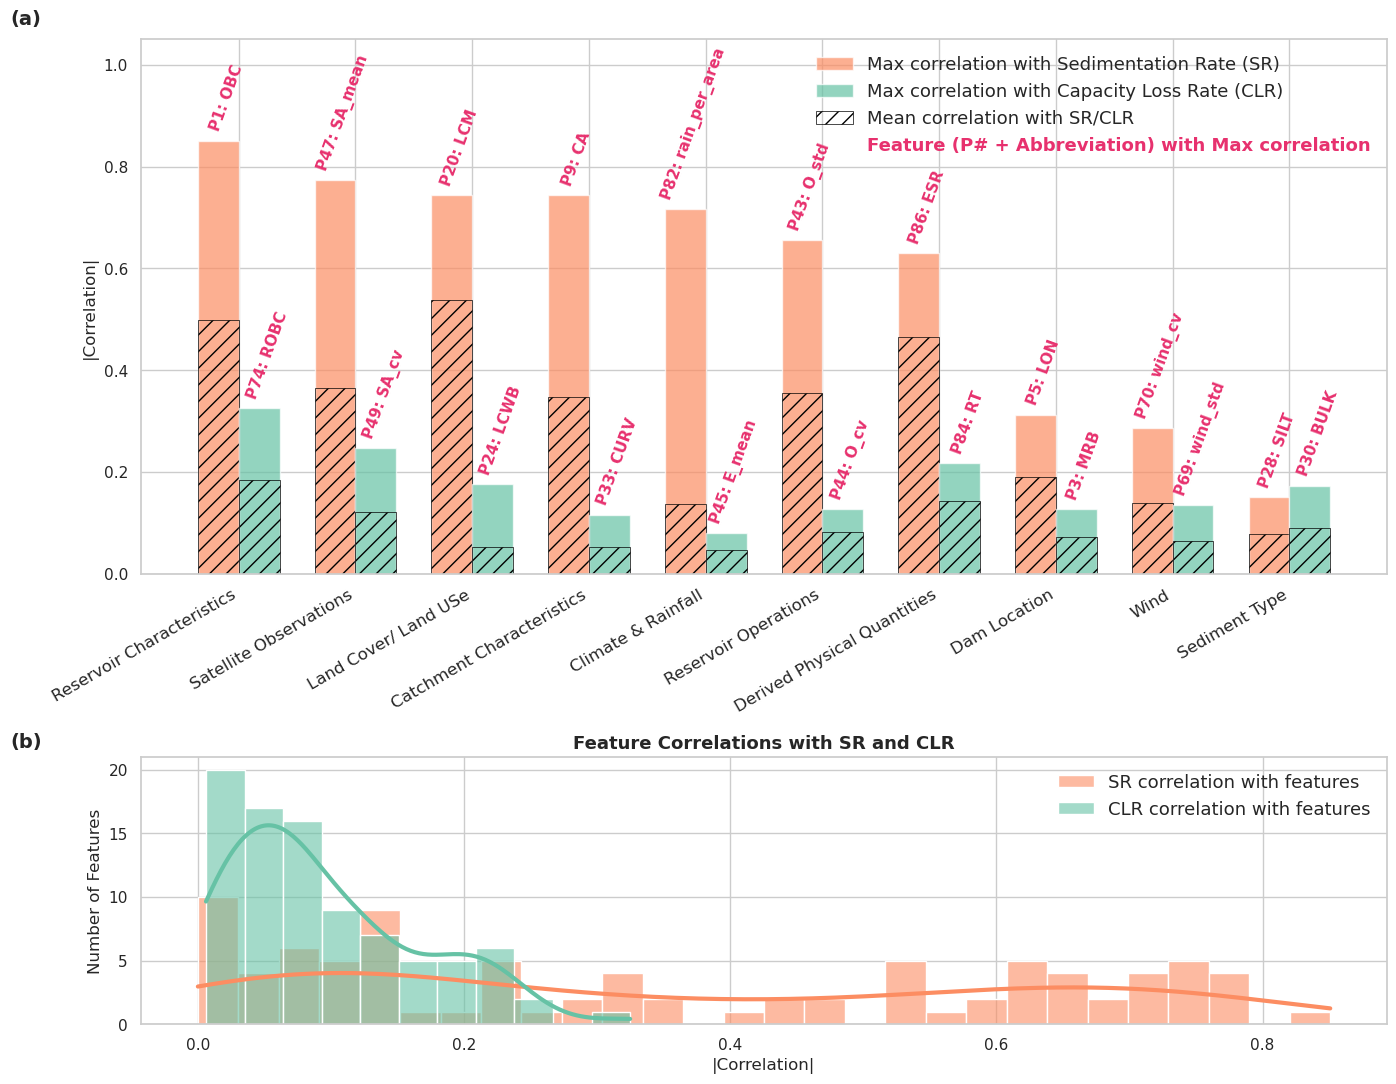

In [41]:
# --- Step 1: Compute correlations (only features + targets) ---
target_cols = ['Capacity Loss Rate (%/year)', 'Sedimentation Rate (MCM/year)']
corrs = df[features + target_cols].corr(method='spearman')[target_cols]

# --- Step 2: Map features to categories ---
category_map = {}
for cat, feats in feature_categories.items():
    for f in feats:
        category_map[f] = cat

# Absolute correlations only for features
corrs_abs = corrs.loc[features].abs()
corrs_abs['Category'] = [category_map[f] for f in features]

# --- Step 3: Aggregate correlations ---
mean_corr = corrs_abs.groupby("Category")[target_cols].mean()
max_corr = corrs_abs.groupby("Category")[target_cols].max()

# Track which feature gave the max
max_features = {}
for cat, feats in feature_categories.items():
    feats_in_df = [f for f in feats if f in features]
    if feats_in_df:
        sub = corrs_abs.loc[feats_in_df, target_cols]
        for t in target_cols:
            idx = sub[t].idxmax()
            val = sub.loc[idx, t]
            feat_pos = ordered_features.index(idx) + 1
            shorthand = shorthand_features[ordered_features.index(idx)]
            max_features[(cat, t)] = (f"P{feat_pos}: {shorthand}", val)

# --- Step 4: Order categories by descending SR max correlation ---
categories = max_corr.sort_values("Sedimentation Rate (MCM/year)", ascending=False).index
x = np.arange(len(categories))

# --- Step 5: Aesthetics ---
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2", 2)  # warm, soft colors
colors = {
    'Sedimentation Rate (MCM/year)': palette[1],
    'Capacity Loss Rate (%/year)': palette[0]
}
bar_width = 0.35
legend_labels = ['Max correlation with Sedimentation Rate (SR)', 'Max correlation with Capacity Loss Rate (CLR)']

from matplotlib.lines import Line2D

## --- Step 6: Plot ---
fig, axes = plt.subplots(2, 1, figsize=(14, 11), gridspec_kw={"height_ratios": [2, 1]})

ax = axes[0]  # Top: grouped bar plots

for i, target in enumerate(['Sedimentation Rate (MCM/year)', 'Capacity Loss Rate (%/year)']):
    # Max correlation (solid bars)
    ax.bar(x + i*bar_width,
           max_corr[target].loc[categories],
           width=bar_width,
           color=colors[target],
           alpha=0.7,
           label=legend_labels[i])

    # Mean correlation (hatched overlay, always below max)
    ax.bar(x + i*bar_width,
           mean_corr[target].loc[categories],
           width=bar_width,
           color='none',
           edgecolor='black',
           hatch='//',
           linewidth=0.5,
           label="Mean correlation with SR/CLR" if i == 1 else "")

    # Annotate with strongest feature ID
    for j, cat in enumerate(categories):
        if (cat, target) in max_features:
            feat_name, val = max_features[(cat, target)]
            ax.text(x[j] + i*bar_width+0.07, val + 0.015,
                    feat_name, ha='center', va='bottom',
                    fontsize=11, rotation=70, color="#e7316e", weight=555)

# --- Formatting (bar plot) ---
ax.set_xticks(x + bar_width/2)
ax.set_xticklabels(categories, rotation=30, ha='right', fontsize=12)
ax.set_ylabel("|Correlation|", fontsize=12)

# Custom legend entry for red text labels
red_label = Line2D([0], [0], color="#e7316e", marker="", linestyle="",
                   label="Feature (P# + Abbreviation) with Max correlation")

handles, labels = ax.get_legend_handles_labels()
handles.append(red_label)
labels.append("Feature (P# + Abbreviation) with Max correlation")

legend = ax.legend(handles, labels, frameon=False, fontsize=13)
legend.get_texts()[-1].set_color("#e7316e")
legend.get_texts()[-1].set_weight(555)
ax.set_ylim(0, 1.05)

# Label subplot (a)
ax.text(-0.08, 1.02, "(a)", transform=ax.transAxes,
        fontsize=14, fontweight="bold", va="bottom", ha="right")

# --- Bottom subplot: Distribution of correlations ---
ax2 = axes[1]

sns.histplot(corrs_abs['Sedimentation Rate (MCM/year)'], 
             kde=True, color=colors['Sedimentation Rate (MCM/year)'], 
             label="SR correlation with features", ax=ax2, alpha=0.6, binwidth=0.03,line_kws={"linewidth": 3.0})

sns.histplot(corrs_abs['Capacity Loss Rate (%/year)'], 
             kde=True, color=colors['Capacity Loss Rate (%/year)'], 
             label="CLR correlation with features", ax=ax2, alpha=0.6,  binwidth=0.03, line_kws={"linewidth": 3.0})

ax2.set_xlabel("|Correlation|", fontsize=12)
ax2.set_ylabel("Number of Features", fontsize=12)
ax2.set_title("Feature Correlations with SR and CLR", fontsize=13, weight="bold")
ax2.legend(frameon=False, fontsize=13)

# Label subplot (b)
ax2.text(-0.08, 1.02, "(b)", transform=ax2.transAxes,
         fontsize=14, fontweight="bold", va="bottom", ha="right")

plt.tight_layout()
plt.savefig('/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/correlation_SR_CLR.png', dpi=300)
plt.show()

In [42]:
#Correlation between SR and CLR
correlations = df[target_cols].corr(method='spearman')
correlations

,Capacity Loss Rate (%/year),Sedimentation Rate (MCM/year)
Capacity Loss Rate (%/year),1.000000,0.236971
Sedimentation Rate (MCM/year),0.236971,1.000000


### Classification of CLT

#### Model 1 CLT XGBOOST: 

In [43]:
# Target (binary classification)
target = 'clr_type_4_class'   # make sure this has only 2 unique values

# Features
X = df[features].copy()

# Ensure categorical features are categorical dtype
for c in cat_features:
    X[c] = X[c].astype('category')

# Target encode
le = LabelEncoder()
y = le.fit_transform(df[target])  

# Original capacity (optional for sample weights)
orig_capacity = df['Original Built Capacity (MCM)']

# Compute reservoir-level target (take first occurrence per reservoir)
reservoir_targets = df.groupby('GRILSS RID')[target].max().reset_index()

# Split by unique reservoir IDs
unique_rids = df['GRILSS RID'].unique()
train_rids, temp_rids = train_test_split(unique_rids, test_size=0.2, stratify=reservoir_targets[target], random_state=42)
val_rids, test_rids   = train_test_split(temp_rids, test_size=0.5, stratify=reservoir_targets.set_index('GRILSS RID').loc[temp_rids][target], random_state=42)

train_mask = df['GRILSS RID'].isin(train_rids)
val_mask   = df['GRILSS RID'].isin(val_rids)
test_mask  = df['GRILSS RID'].isin(test_rids)

X_train, y_train, cap_train = X[train_mask], y[train_mask], orig_capacity[train_mask]
X_val,   y_val,   cap_val   = X[val_mask],   y[val_mask],   orig_capacity[val_mask]
X_test,  y_test,  cap_test  = X[test_mask],  y[test_mask],  orig_capacity[test_mask]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

Train: (1046, 88) Validation: (148, 88) Test: (121, 88)


In [44]:
# Custom evaluation metric for XGBoost
num_classes = len(np.unique(y_train))

model = xgb.XGBClassifier(
    n_estimators=1500,
    learning_rate=0.015,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.8,
    objective='multi:softprob',  
    reg_alpha=7,
    reg_lambda=5,
    random_state=42,
    n_jobs=-1,
    enable_categorical=True,
    eval_metric='mlogloss',
)

# Train with custom eval metric
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# Predict
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))

[0]	validation_0-mlogloss:1.37845
[100]	validation_0-mlogloss:1.00530
[200]	validation_0-mlogloss:0.91633
[300]	validation_0-mlogloss:0.87858
[400]	validation_0-mlogloss:0.86310
[500]	validation_0-mlogloss:0.85455
[600]	validation_0-mlogloss:0.85108
[700]	validation_0-mlogloss:0.84850
[800]	validation_0-mlogloss:0.85049
[900]	validation_0-mlogloss:0.85069
[1000]	validation_0-mlogloss:0.84998
[1100]	validation_0-mlogloss:0.85113
[1200]	validation_0-mlogloss:0.85141
[1300]	validation_0-mlogloss:0.85061
[1400]	validation_0-mlogloss:0.85106
[1499]	validation_0-mlogloss:0.85164
Train Accuracy: 0.9579349904397706
Validation Accuracy: 0.6013513513513513
Test Accuracy: 0.5537190082644629

Classification Report (Validation):
              precision    recall  f1-score   support

        High       0.20      0.10      0.13        20
         Low       0.66      0.94      0.78        86
      Medium       0.25      0.10      0.14        31
      Severe       0.75      0.27      0.40        11

  

#### Model 2 CLT LightGBM

In [45]:
# ---------------------------
# Features & Target
# ---------------------------
target = 'clr_type_4_class'
X = df[features].copy()

# Identify categorical features
for c in cat_features:
    X[c] = X[c].astype('category')

# Encode target
le = LabelEncoder()
y = le.fit_transform(df[target])

# Compute reservoir-level target (take first occurrence per reservoir)
reservoir_targets = df.groupby('GRILSS RID')[target].max().reset_index()

# Split by unique reservoir IDs
unique_rids = df['GRILSS RID'].unique()
train_rids, temp_rids = train_test_split(unique_rids, test_size=0.2, stratify=reservoir_targets[target], random_state=42)
val_rids, test_rids   = train_test_split(temp_rids, test_size=0.5, stratify=reservoir_targets.set_index('GRILSS RID').loc[temp_rids][target], random_state=42)

train_mask = df['GRILSS RID'].isin(train_rids)
val_mask   = df['GRILSS RID'].isin(val_rids)
test_mask  = df['GRILSS RID'].isin(test_rids)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val     = X[val_mask], y[val_mask]
X_test, y_test   = X[test_mask], y[test_mask]

# ---------------------------
# LightGBM datasets
# ---------------------------
train_data = lgb.Dataset(X_train, label=y_train,  categorical_feature=cat_features)
val_data   = lgb.Dataset(X_val, label=y_val,  categorical_feature=cat_features, reference=train_data)

# ---------------------------
# Macro F1 metric for LightGBM
# ---------------------------
def macro_f1_lgb(preds, train_data):
    num_class = len(np.unique(y_train))
    labels = train_data.get_label()
    preds = preds.reshape(num_class, -1).T
    preds = np.argmax(preds, axis=1)
    return 'macro_f1', f1_score(labels, preds, average='macro'), True  # True = higher is better

# ---------------------------
# LightGBM parameters
# ---------------------------
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'learning_rate': 0.05,
    'num_leaves': 32,
    'max_depth': 6,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'lambda_l1': 10,
    'lambda_l2': 3,
    'verbosity': -1,
    'seed': 42
}

# ---------------------------
# Train LightGBM
# ---------------------------
clf = lgb.train(
    params,
    train_data,
    num_boost_round=1200,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    feval=macro_f1_lgb,
)

# ---------------------------
# Predictions
# ---------------------------
y_pred_train = np.argmax(clf.predict(X_train), axis=1)
y_pred_val   = np.argmax(clf.predict(X_val), axis=1)
y_pred_test  = np.argmax(clf.predict(X_test), axis=1)

# ---------------------------
# Metrics
# ---------------------------
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))

Train Accuracy: 0.8824091778202677
Validation Accuracy: 0.6081081081081081
Test Accuracy: 0.5371900826446281

Classification Report (Validation):
              precision    recall  f1-score   support

        High       0.18      0.10      0.13        20
         Low       0.67      0.94      0.78        86
      Medium       0.38      0.16      0.23        31
      Severe       0.67      0.18      0.29        11

    accuracy                           0.61       148
   macro avg       0.48      0.35      0.36       148
weighted avg       0.54      0.61      0.54       148


Classification Report (Test):
              precision    recall  f1-score   support

        High       0.42      0.22      0.29        23
         Low       0.60      0.89      0.72        57
      Medium       0.21      0.10      0.14        30
      Severe       0.60      0.55      0.57        11

    accuracy                           0.54       121
   macro avg       0.46      0.44      0.43       121
weighted

#### Model 3 CLT CatBoost

In [46]:
# ---------------------------
# Features & Target
# ---------------------------
target = 'clr_type_4_class'
X = df[features].copy()

# Encode categorical features
for c in cat_features:
    X[c] = X[c].astype('int')

# Encode target
le = LabelEncoder()
y = le.fit_transform(df[target])

# Compute reservoir-level target (take first occurrence per reservoir)
reservoir_targets = df.groupby('GRILSS RID')[target].max().reset_index()

# Split by unique reservoir IDs
unique_rids = df['GRILSS RID'].unique()
train_rids, temp_rids = train_test_split(unique_rids, test_size=0.2, stratify=reservoir_targets[target], random_state=42)
val_rids, test_rids   = train_test_split(temp_rids, test_size=0.5, stratify=reservoir_targets.set_index('GRILSS RID').loc[temp_rids][target], random_state=42)

train_mask = df['GRILSS RID'].isin(train_rids)
val_mask   = df['GRILSS RID'].isin(val_rids)
test_mask  = df['GRILSS RID'].isin(test_rids)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val     = X[val_mask], y[val_mask]
X_test, y_test   = X[test_mask], y[test_mask]

# ---------------------------
# Class Weights (custom or computed)
# ---------------------------
# Option A: custom weights (your provided dictionary)
class_weight_dict = {0: 2.5, 1: 1.0, 2: 1.8, 3: 2.8}

# Option B: automatic balancing
# counter = Counter(y_train)
# max_count = max(counter.values())
# class_weight_dict = {cls: np.sqrt(max_count / count) for cls, count in counter.items()}

# ---------------------------
# Create CatBoost Pools
# ---------------------------
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
val_pool   = Pool(X_val, label=y_val, cat_features=cat_features)
test_pool  = Pool(X_test, label=y_test, cat_features=cat_features)

# ---------------------------
# CatBoost Parameters
# ---------------------------
clf = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.06,
    depth=6,
    l2_leaf_reg=8,
    random_seed=42,
    eval_metric='TotalF1',  # macro-F1
    loss_function='MultiClass',
    early_stopping_rounds=200,
    # class_weights=[class_weight_dict[i] for i in range(len(le.classes_))],
    verbose=100
)

# ---------------------------
# Train CatBoost
# ---------------------------
clf.fit(train_pool, eval_set=val_pool, use_best_model=True)

# ---------------------------
# Predictions
# ---------------------------
y_pred_train = clf.predict(train_pool).astype(int).flatten()
y_pred_val   = clf.predict(val_pool).astype(int).flatten()
y_pred_test  = clf.predict(test_pool).astype(int).flatten()

# ---------------------------
# Metrics
# ---------------------------
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))

0:	learn: 0.4490076	test: 0.4791667	best: 0.4791667 (0)	total: 62.2ms	remaining: 1m 33s
100:	learn: 0.6357550	test: 0.4564064	best: 0.4823816 (1)	total: 1.04s	remaining: 14.4s
200:	learn: 0.7999561	test: 0.5099407	best: 0.5099407 (200)	total: 2.04s	remaining: 13.2s
300:	learn: 0.8653590	test: 0.5252018	best: 0.5257786 (271)	total: 3.08s	remaining: 12.3s
400:	learn: 0.9069818	test: 0.5287243	best: 0.5469626 (391)	total: 4.08s	remaining: 11.2s
500:	learn: 0.9350062	test: 0.5252331	best: 0.5469626 (391)	total: 5.1s	remaining: 10.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5469626095
bestIteration = 391

Shrink model to first 392 iterations.
Train Accuracy: 0.9063097514340345
Validation Accuracy: 0.6216216216216216
Test Accuracy: 0.5702479338842975

Classification Report (Validation):
              precision    recall  f1-score   support

        High       0.23      0.15      0.18        20
         Low       0.68      0.97      0.80        86
      Medium     

#### Performance plot for CLT Models

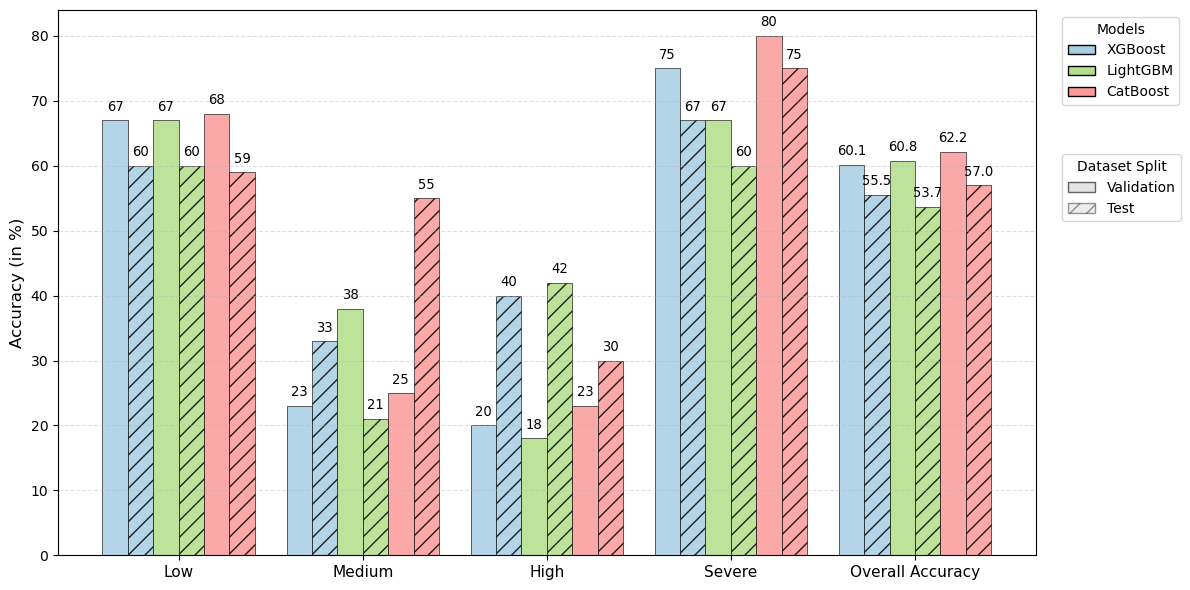

In [87]:
# ---------------------------
# Data
# ---------------------------
data = {
    "Class": ["Low", "Medium", "High", "Severe", "Overall Accuracy"],
    "XGBoost_Val": [67, 23, 20, 75, 60.13],
    "XGBoost_Test": [60, 33, 40, 67, 55.54],
    "LightGBM_Val": [67, 38, 18, 67, 60.81],
    "LightGBM_Test": [60, 21, 42, 60, 53.72],
    "CatBoost_Val": [68, 25, 23, 80, 62.16],
    "CatBoost_Test": [59, 55, 30, 75, 57],
}
performance_df_clt = pd.DataFrame(data)

# ---------------------------
# Plot setup
# ---------------------------
fig, ax = plt.subplots(figsize=(12, 6))

models = ["XGBoost", "LightGBM", "CatBoost"]
splits = ["Val", "Test"]

# Softer pastel colors
colors = {"XGBoost": "#a6cee3", "LightGBM": "#b2df8a", "CatBoost": "#fb9a99"}
hatches = {"Val": "", "Test": "//"}

n_groups = len(performance_df_clt["Class"])
n_bars_per_group = len(models) * len(splits)  # 6 bars per class
bar_width = 0.12
group_width = n_bars_per_group * bar_width + 0.15  # spacing between groups

# ---------------------------
# Plot bars
# ---------------------------
for group_idx, cls in enumerate(performance_df_clt["Class"]):
    for i, model in enumerate(models):
        for j, split in enumerate(splits):
            col = f"{model}_{split}"
            bar_index = i * len(splits) + j
            x_pos = group_idx * group_width + bar_index * bar_width
            height = performance_df_clt.loc[group_idx, col]

            ax.bar(
                x_pos,
                height,
                width=bar_width,
                color=colors[model],
                hatch=hatches[split],
                edgecolor="black",
                alpha=0.85,
                linewidth=0.5,   # lighter edges
            )

            # Add value labels on top
            if cls == "Overall Accuracy":  # only for overall accuracy
                decimal_no = 1
            else:
                decimal_no = 0
            ax.text(
                x_pos,
                height + 1,
                f"{height:.{decimal_no}f}",
                ha="center",
                va="bottom",
                fontsize=9.5,
                rotation=0
            )

# ---------------------------
# Formatting
# ---------------------------
x_positions = [
    group_idx * group_width + (n_bars_per_group - 1) * bar_width / 2
    for group_idx in range(n_groups)
]
ax.set_xticks(x_positions)
ax.set_xticklabels(performance_df_clt["Class"], fontsize=11)

ax.set_ylabel("Accuracy (in %)", fontsize=12)
# ax.set_title("Model Comparison by Class (Validation vs Test)", fontsize=14, weight="bold")
ax.grid(axis="y", linestyle="--", alpha=0.4)

# ---------------------------
# Custom Legends
# ---------------------------
model_handles = [Patch(facecolor=colors[m], edgecolor="black", label=m) for m in models]
split_handles = [
    Patch(facecolor="lightgray", label="Validation", alpha=0.6, edgecolor="black"),
    Patch(facecolor="lightgray", label="Test", hatch="//", alpha=0.4, edgecolor="black"),
]

legend1 = ax.legend(handles=model_handles, title="Models", loc="upper left", bbox_to_anchor=(1.02, 1))
legend2 = ax.legend(handles=split_handles, title="Dataset Split", loc="lower left", bbox_to_anchor=(1.02, 0.6))
ax.add_artist(legend1)

plt.tight_layout()
plt.savefig('/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/CLT_model_comparison.png', dpi=300)
plt.show()

In [47]:
clr_model_performance = {}
clr_models = {}

#### Model 1 CLR XGBoost

In [48]:
# --- Features & Target ---
X = df[features]
y = df['Capacity Loss Rate (%/year)'].clip(0.01)
orig_capacity = df['Original Built Capacity (MCM)']

# --- Split by unique reservoir IDs ---
unique_rids = df['GRILSS RID'].unique()
train_rids, temp_rids = train_test_split(unique_rids, test_size=0.2, random_state=45)
val_rids, test_rids = train_test_split(temp_rids, test_size=0.5, random_state=45)

train_mask = df['GRILSS RID'].isin(train_rids)
val_mask   = df['GRILSS RID'].isin(val_rids)
test_mask  = df['GRILSS RID'].isin(test_rids)

X_train, y_train, cap_train = X[train_mask], y[train_mask], orig_capacity[train_mask]
X_val, y_val, cap_val       = X[val_mask], y[val_mask], orig_capacity[val_mask]
X_test, y_test, cap_test    = X[test_mask], y[test_mask], orig_capacity[test_mask]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

# --- Sample weights ---
weight_train = np.where(cap_train > 10, 5, 1)
weight_val   = np.where(cap_val > 10, 5, 1)

# --- Initialize XGBoost Regressor ---
xgb_model = xgb.XGBRegressor(
    n_estimators=1200,
    learning_rate=0.006,
    max_depth=8,
    objective='reg:squarederror',  # can also use 'reg:pseudohubererror' if supported
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=2,
    reg_lambda=3,
    random_state=42
)

# --- Train ---
xgb_model.fit(
    X_train, y_train,
    sample_weight=weight_train,
    eval_set=[(X_val, y_val)],
    sample_weight_eval_set=[weight_val],
)

# --- Predict ---
y_pred_train = np.clip(xgb_model.predict(X_train), 0, None)
y_pred_val   = np.clip(xgb_model.predict(X_val), 0, None)
y_pred_test  = np.clip(xgb_model.predict(X_test), 0, None)

# --- Metrics ---
def print_metrics(name, y_true, y_pred):
    y_true = y_true.values.flatten() if isinstance(y_true, pd.Series) else y_true
    y_pred = y_pred.flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("\nCapacity Loss Rate Performance (XGBoost):")
print_metrics("Train", y_train, y_pred_train)
print_metrics("Validation", y_val, y_pred_val)
print_metrics("Test", y_test, y_pred_test)

Train: (1076, 88) Validation: (106, 88) Test: (133, 88)
[0]	validation_0-rmse:2.55254
[1]	validation_0-rmse:2.54916
[2]	validation_0-rmse:2.54643
[3]	validation_0-rmse:2.54458
[4]	validation_0-rmse:2.53891
[5]	validation_0-rmse:2.53814
[6]	validation_0-rmse:2.53771
[7]	validation_0-rmse:2.53353
[8]	validation_0-rmse:2.53329
[9]	validation_0-rmse:2.53178
[10]	validation_0-rmse:2.52921
[11]	validation_0-rmse:2.52479
[12]	validation_0-rmse:2.52317
[13]	validation_0-rmse:2.52297
[14]	validation_0-rmse:2.52193
[15]	validation_0-rmse:2.51905
[16]	validation_0-rmse:2.51548
[17]	validation_0-rmse:2.51436
[18]	validation_0-rmse:2.51030
[19]	validation_0-rmse:2.50436
[20]	validation_0-rmse:2.50246
[21]	validation_0-rmse:2.50215
[22]	validation_0-rmse:2.50192
[23]	validation_0-rmse:2.50022
[24]	validation_0-rmse:2.49927
[25]	validation_0-rmse:2.49786
[26]	validation_0-rmse:2.49767
[27]	validation_0-rmse:2.49283
[28]	validation_0-rmse:2.49277
[29]	validation_0-rmse:2.49205
[30]	validation_0-rmse:2

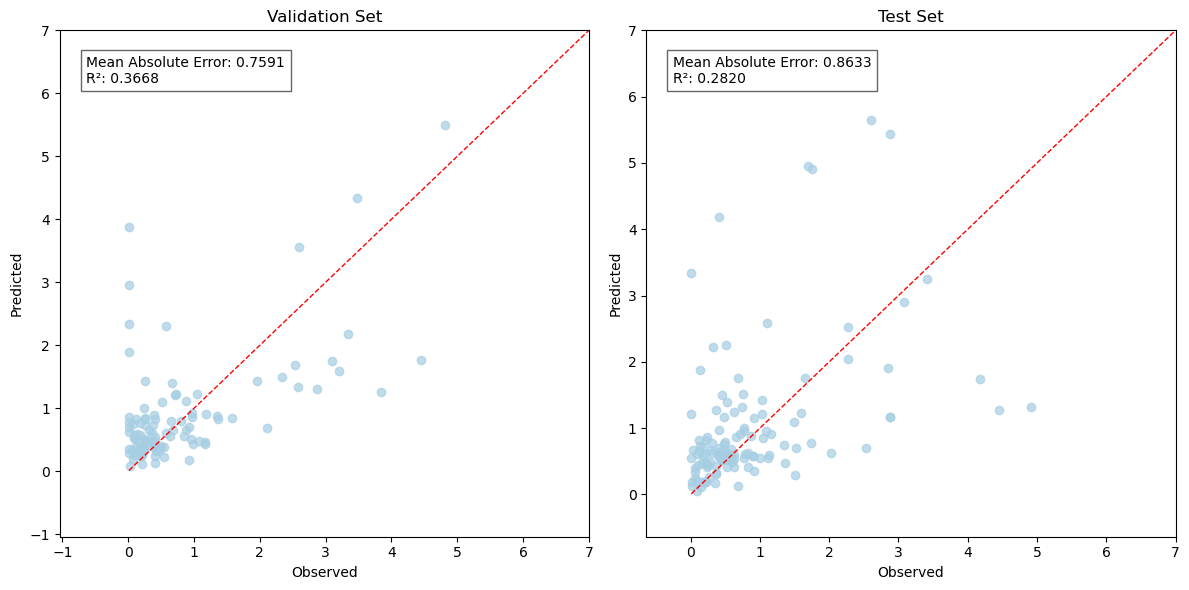

In [536]:
plot_observed_vs_predicted(y_val, y_pred_val, y_test, y_pred_test,scatter_colors=(colors['XGBoost'],colors['XGBoost']), zoom=7)

In [49]:
clr_model_performance['XGBoost'] = {'validation': (y_val, y_pred_val), 'test': (y_test, y_pred_test)}
clr_models['XGBoost'] = xgb_model

#### Model 2 CLR LightGBM

In [50]:
# --- Features & Target ---
X = df[features]
y = df['Capacity Loss Rate (%/year)'].clip(0.01)  # avoid zeros
orig_capacity = df['Original Built Capacity (MCM)']

# --- Split by unique reservoir IDs ---
unique_rids = df['GRILSS RID'].unique()
train_rids, temp_rids = train_test_split(unique_rids, test_size=0.2, random_state=45)
val_rids, test_rids = train_test_split(temp_rids, test_size=0.5, random_state=45)

train_mask = df['GRILSS RID'].isin(train_rids)
val_mask   = df['GRILSS RID'].isin(val_rids)
test_mask  = df['GRILSS RID'].isin(test_rids)

X_train, y_train, cap_train = X[train_mask], y[train_mask], orig_capacity[train_mask]
X_val, y_val, cap_val       = X[val_mask], y[val_mask], orig_capacity[val_mask]
X_test, y_test, cap_test    = X[test_mask], y[test_mask], orig_capacity[test_mask]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

# --- Sample weights ---
weight_train = np.where(cap_train > 10, 10, 1)
weight_val   = np.where(cap_val > 10, 10, 1)

# --- Create LightGBM datasets ---
train_data = lgb.Dataset(X_train, label=y_train, weight=weight_train)
val_data   = lgb.Dataset(X_val, label=y_val, weight=weight_val, reference=train_data)

# --- LightGBM parameters ---
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 8,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 10,
    'lambda_l2': 10,
    'verbosity': -1,
    'seed': 42
}

# --- Train LightGBM ---
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1200,
    valid_sets=[train_data, val_data],
    valid_names=['train','val'],
)

# --- Predict ---
y_pred_train = np.clip(lgb_model.predict(X_train), 0, None)
y_pred_val   = np.clip(lgb_model.predict(X_val), 0, None)
y_pred_test  = np.clip(lgb_model.predict(X_test), 0, None)

# --- Metrics ---
def print_metrics(name, y_true, y_pred):
    y_true = y_true.values.flatten() if isinstance(y_true, pd.Series) else y_true
    y_pred = y_pred.flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("\nCapacity Loss Rate Performance (LightGBM):")
print_metrics("Train", y_train, y_pred_train)
print_metrics("Validation", y_val, y_pred_val)
print_metrics("Test", y_test, y_pred_test)

Train: (1076, 88) Validation: (106, 88) Test: (133, 88)

Capacity Loss Rate Performance (LightGBM):
Train RMSE: 1.2697 | MAE: 0.1765 | R²: 0.8844
Validation RMSE: 2.0765 | MAE: 0.9045 | R²: 0.2052
Test RMSE: 1.9649 | MAE: 1.0588 | R²: 0.1619


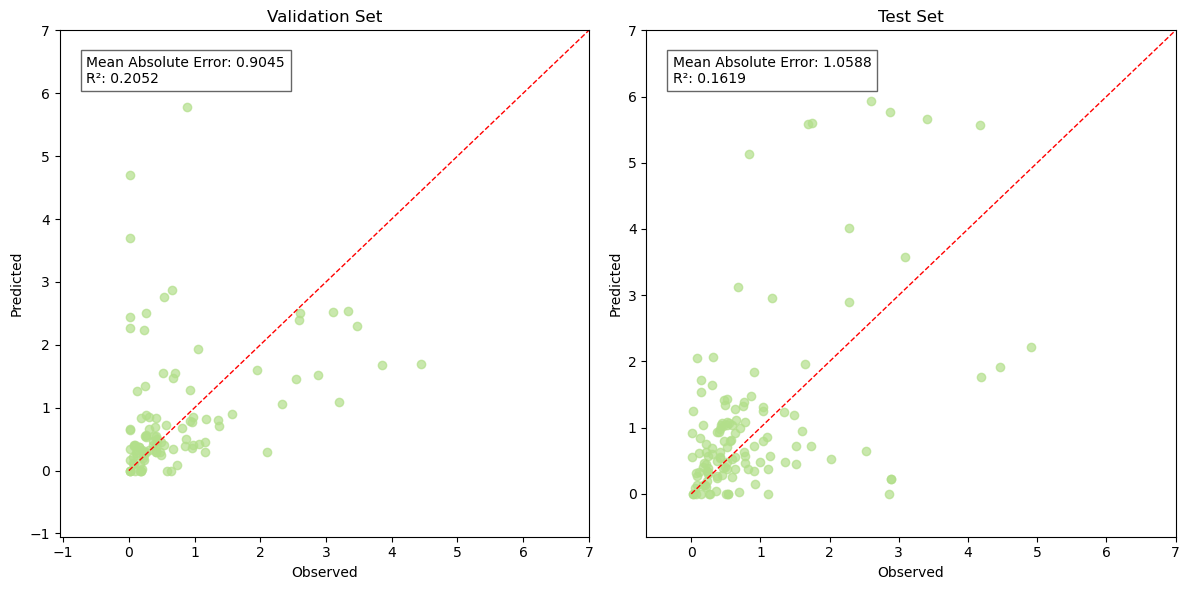

In [103]:
plot_observed_vs_predicted(y_val, y_pred_val, y_test, y_pred_test,scatter_colors=(colors['LightGBM'],colors['LightGBM']), zoom=7)

In [51]:
clr_model_performance['LightGBM'] = {'validation': (y_val, y_pred_val), 'test': (y_test, y_pred_test)}
clr_models['LightGBM'] = lgb_model

#### Model 3 CLR CatBoost

In [52]:
X = df[features]
y = df['Capacity Loss Rate (%/year)'].clip(0.01)

orig_capacity = df['Original Built Capacity (MCM)']  # needed later

# Encode categorical features
for c in cat_features:
    X[c] = X[c].astype('int')

# Get unique reservoir IDs
unique_rids = df['GRILSS RID'].unique()

# Split reservoirs into train (80%) and temp (20% for val+test)
train_rids, temp_rids = train_test_split(
    unique_rids, test_size=0.2, random_state=45
)

# Split temp into validation and test (50/50 → 10% each overall)
val_rids, test_rids = train_test_split(
    temp_rids, test_size=0.5, random_state=45
)

# Create boolean masks
train_mask = df['GRILSS RID'].isin(train_rids)
val_mask   = df['GRILSS RID'].isin(val_rids)
test_mask  = df['GRILSS RID'].isin(test_rids)

# Split data
X_train = X[train_mask]
y_train = y[train_mask]
cap_train = orig_capacity[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]
cap_val = orig_capacity[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]
cap_test = orig_capacity[test_mask]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

weight_train = pd.Series([5 if x > 10 else 1 for x in cap_train], index=cap_train.index)
weight_val  = pd.Series([5 if x > 10 else 1 for x in cap_val], index=cap_val.index)


Train: (1076, 88) Validation: (106, 88) Test: (133, 88)


/tmp/ipykernel_628064/2307084816.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('int')
/tmp/ipykernel_628064/2307084816.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('int')


In [53]:
# ---- Prepare CatBoost Pools ----
train_pool = Pool(
    data=X_train,
    label=y_train,
    # weight=weight_train.values,
    cat_features=cat_features
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    # weight=weight_val.values,
    cat_features=cat_features
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)

# ---- Initialize CatBoost Regressor ----
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.3,
    depth=6,
    objective='RMSE',
    l2_leaf_reg=20,
    random_seed=42,
    eval_metric='MAE',
    verbose=100
)

# ---- Train ----
model.fit(
    train_pool,
    eval_set=val_pool,
    early_stopping_rounds=100,
    use_best_model=True
)

# ---- Predict & inverse transform ----
y_pred_train = model.predict(train_pool)
y_pred_val   = model.predict(val_pool)
y_pred_test  = model.predict(test_pool)

y_pred_train = np.clip(y_pred_train, 0, None)
y_pred_val   = np.clip(y_pred_val, 0, None)
y_pred_test  = np.clip(y_pred_test, 0, None)

# --- Metrics ---
def print_metrics(name, y_true, y_pred):
    y_true = y_true.values.flatten() if isinstance(y_true, pd.Series) else y_true
    y_pred = y_pred.flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("\nCapacity Loss Rate Performance (CatBoost Tweedie):")
print_metrics("Train", y_train, y_pred_train)
print_metrics("Validation", y_val, y_pred_val)
print_metrics("Test", y_test, y_pred_test)

0:	learn: 0.9332595	test: 1.0414118	best: 1.0414118 (0)	total: 8.13ms	remaining: 16.3s
100:	learn: 0.7135208	test: 0.9758273	best: 0.9681716 (88)	total: 427ms	remaining: 8.02s
200:	learn: 0.4000665	test: 0.7973748	best: 0.7973748 (200)	total: 852ms	remaining: 7.63s
300:	learn: 0.2275747	test: 0.7517304	best: 0.7514825 (293)	total: 1.33s	remaining: 7.51s
400:	learn: 0.1484894	test: 0.7368024	best: 0.7366588 (384)	total: 1.81s	remaining: 7.22s
500:	learn: 0.1002204	test: 0.7336686	best: 0.7336686 (500)	total: 2.3s	remaining: 6.88s
600:	learn: 0.0714759	test: 0.7342612	best: 0.7317552 (522)	total: 2.79s	remaining: 6.49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7317551663
bestIteration = 522

Shrink model to first 523 iterations.

Capacity Loss Rate Performance (CatBoost Tweedie):
Train RMSE: 0.1321 | MAE: 0.0949 | R²: 0.9987
Validation RMSE: 1.8080 | MAE: 0.7275 | R²: 0.3975
Test RMSE: 1.8311 | MAE: 0.8247 | R²: 0.2722


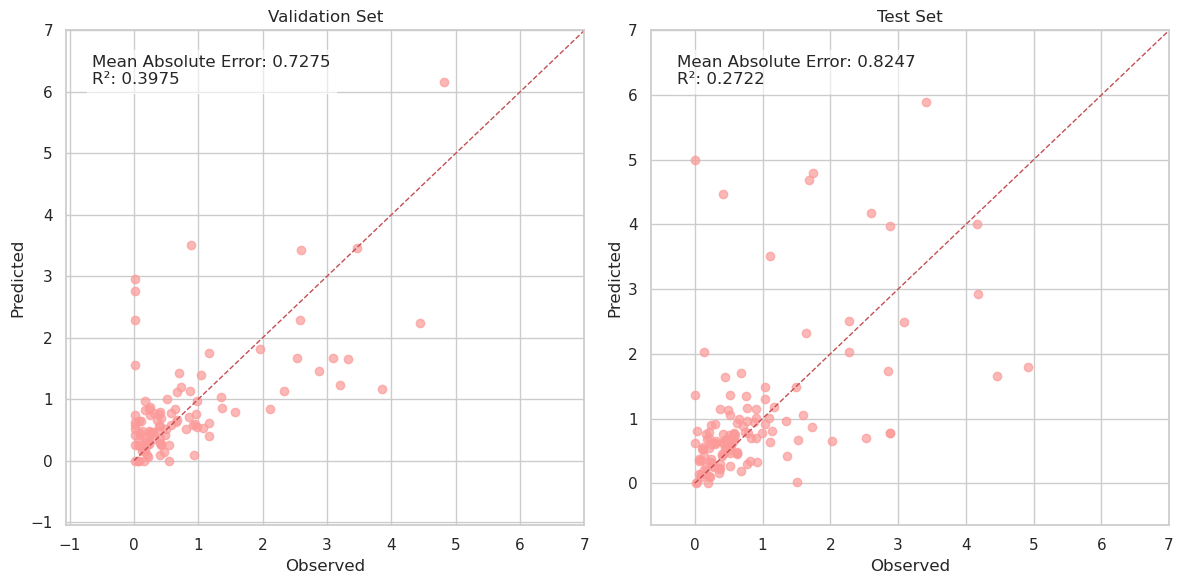

In [56]:
plot_observed_vs_predicted(y_val, y_pred_val, y_test, y_pred_test,scatter_colors=(colors['CatBoost'],colors['CatBoost']), zoom=7)

In [57]:
clr_model_performance['CatBoost'] = {'validation': (y_val, y_pred_val), 'test': (y_test, y_pred_test)}
clr_models['CatBoost'] = model

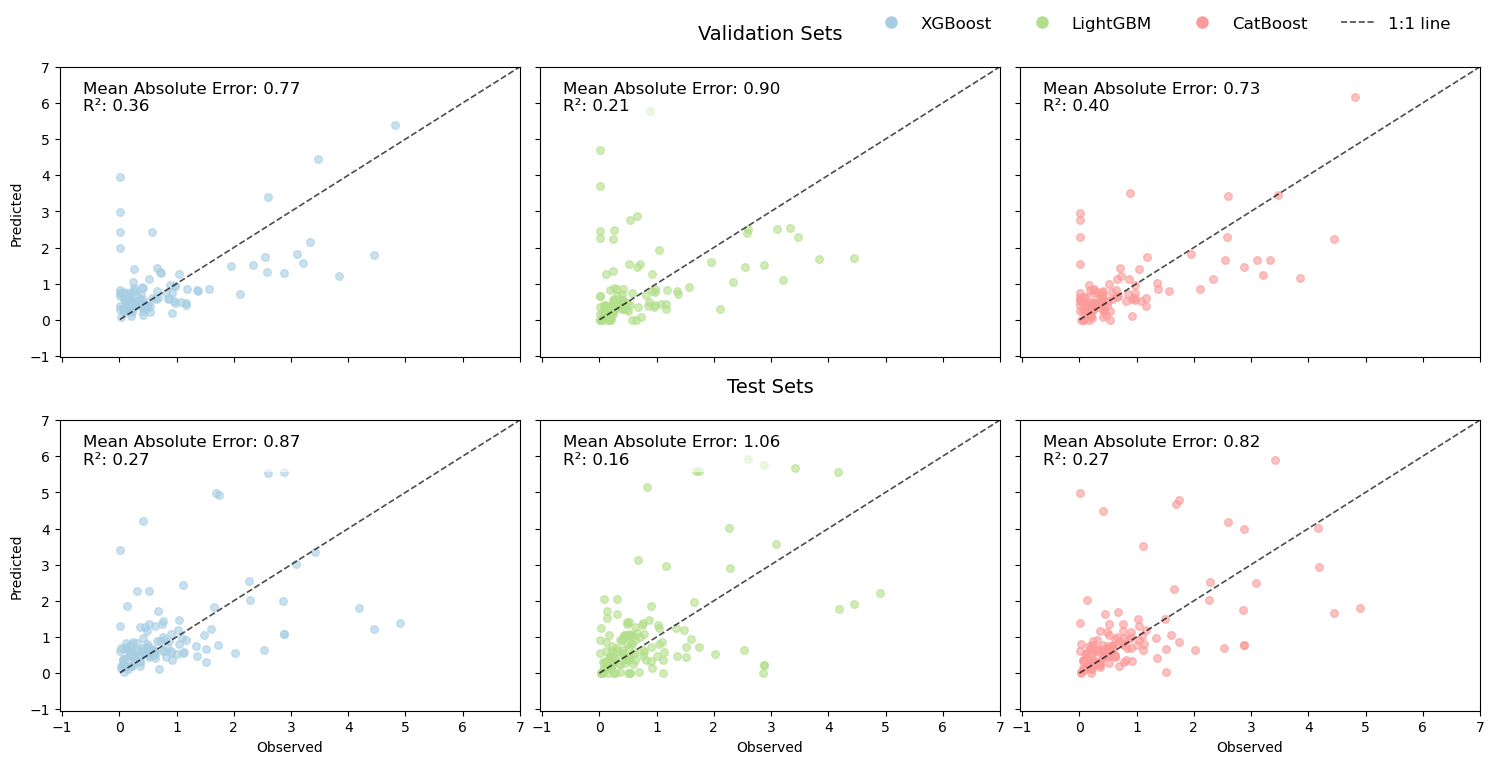

In [109]:

plot_model_comparison_regression(clr_model_performance, colors= {"XGBoost": "#a6cee3", "LightGBM": "#b2df8a", "CatBoost": "#fb9a99"}, zoom =7,
                                 savepath = '/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/CLR_model_comparison.png')

#### CLR Statistics

In [58]:
print("Mean of all capacity loss rates: ", y.mean()) 
print("Variance of all capacity loss rates: ", y.var())
print("Standard Deviation of all capacity loss rates: ", y.std())

Mean of all capacity loss rates:  1.015356600097642
Variance of all capacity loss rates:  12.324374193023175
Standard Deviation of all capacity loss rates:  3.5106088066065086


In [59]:
print("Percentage of values below 1%: ", (y < 2).mean() * 100)

Percentage of values below 1%:  90.34220532319391


### Sedimentation Rate

In [60]:
sr_model_performance = {}

#### Model 1 SR - XgBoost

In [61]:
# # Define XGBoost Regressor
# model = xgb.XGBRegressor(
#     n_estimators=2000,
#     learning_rate=0.03,
#     tweedie_variance_power=1.65,
#     max_depth=6,
#     subsample=0.7,
#     colsample_bytree=0.7,
#     objective='reg:tweedie',
#     reg_alpha=25,
#     reg_lambda=5,
#     # objective='reg:squaredlogerror',  # robust for skewed targets
#     random_state=42,
#     n_jobs=-1
# )

In [62]:
colors = {"XGBoost": "#a6cee3", "LightGBM": "#b2df8a", "CatBoost": "#fb9a99", "average":"#be7dfaf1", "RECLAIM": "#be7dfaf1"} 

In [63]:
X = df[features]
y = df['Sedimentation Rate (MCM/year)'].clip(0)
orig_capacity = df['Original Built Capacity (MCM)']  # needed later


# Get unique reservoir IDs
unique_rids = df['GRILSS RID'].unique()

# Split reservoirs into train (80%) and temp (20% for val+test)
train_rids, temp_rids = train_test_split(
    unique_rids, test_size=0.2, random_state=45
)

# Split temp into validation and test (50/50 → 10% each overall)
val_rids, test_rids = train_test_split(
    temp_rids, test_size=0.5, random_state=45
)

# Create boolean masks
train_mask = df['GRILSS RID'].isin(train_rids)
val_mask   = df['GRILSS RID'].isin(val_rids)
test_mask  = df['GRILSS RID'].isin(test_rids)

# Split data
X_train = X[train_mask]
y_train = y[train_mask]
cap_train = orig_capacity[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]
cap_val = orig_capacity[val_mask]


X_test = X[test_mask]
y_test = y[test_mask]
cap_test = orig_capacity[test_mask]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

weight_train = pd.Series([5 if x > 10 else 1 for x in cap_train], index=cap_train.index)
weight_val  = pd.Series([5 if x > 10 else 1 for x in cap_val], index=cap_val.index)


# Define XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    tweedie_variance_power=1.5,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='reg:tweedie',
    reg_alpha=70,
    reg_lambda=30,
    # objective='reg:squaredlogerror',  # robust for skewed targets
    random_state=42,
    n_jobs=-1
)

# Train model
model.fit(
    X_train, y_train,
    sample_weight=weight_train.values,
    eval_set=[(X_val, y_val)],
    sample_weight_eval_set=[(weight_val.values)],
    verbose=False
)

# Predict & inverse transform
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)


# Clip to avoid negative values
y_pred = np.clip(y_pred_test, 0, None)
y_pred_val = np.clip(y_pred_val, 0, None)
y_pred_train = np.clip(y_pred_train, 0, None)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"Sedimentation Rate Test RMSE: {rmse:.4f}")
print(f"Sedimentation Rate Test MAE: {mae:.4f}")
print(f"Sedimentation Rate Test R²:   {r2:.4f}")

print(f"Sedimentation Rate Val RMSE: {rmse_val:.4f}")
print(f"Sedimentation Rate Val MAE: {mae_val:.4f}")
print(f"Sedimentation Rate Val R²:   {r2_val:.4f}")

print(f"Sedimentation Rate Train RMSE: {rmse_train:.4f}")
print(f"Sedimentation Rate Train MAE: {mae_train:.4f}")
print(f"Sedimentation Rate Train R²:   {r2_train:.4f}")

Train: (1076, 88) Validation: (106, 88) Test: (133, 88)
Sedimentation Rate Test RMSE: 5.2349
Sedimentation Rate Test MAE: 1.9046
Sedimentation Rate Test R²:   0.8053
Sedimentation Rate Val RMSE: 3.7783
Sedimentation Rate Val MAE: 1.3282
Sedimentation Rate Val R²:   0.8778
Sedimentation Rate Train RMSE: 1.6007
Sedimentation Rate Train MAE: 0.5839
Sedimentation Rate Train R²:   0.9888


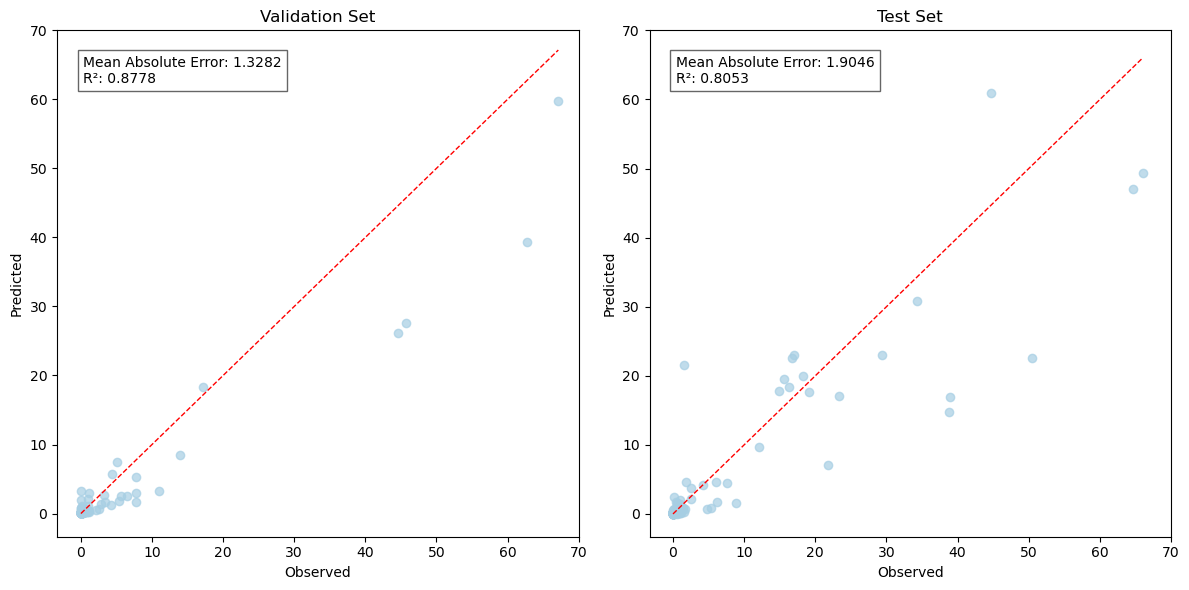

In [116]:
plot_observed_vs_predicted(y_val, y_pred_val, y_test, y_pred_test,scatter_colors=(colors['XGBoost'],colors['XGBoost']), zoom=70)

In [64]:
sr_model_performance['XGBoost'] = {'train': (y_train, y_pred_train), 'validation': (y_val, y_pred_val), 'test': (y_test, y_pred_test)}

##### Model 2 SR - LightGBM

In [65]:
X = df[features]
y = df['Sedimentation Rate (MCM/year)'].clip(0)
orig_capacity = df['Original Built Capacity (MCM)']  # needed later


# Get unique reservoir IDs
unique_rids = df['GRILSS RID'].unique()

# Split reservoirs into train (80%) and temp (20% for val+test)
train_rids, temp_rids = train_test_split(
    unique_rids, test_size=0.2, random_state=45
)

# Split temp into validation and test (50/50 → 10% each overall)
val_rids, test_rids = train_test_split(
    temp_rids, test_size=0.5, random_state=45
)

# Create boolean masks
train_mask = df['GRILSS RID'].isin(train_rids)
val_mask   = df['GRILSS RID'].isin(val_rids)
test_mask  = df['GRILSS RID'].isin(test_rids)

# Split data
X_train = X[train_mask]
y_train = y[train_mask]
cap_train = orig_capacity[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]
cap_val = orig_capacity[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]
cap_test = orig_capacity[test_mask]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

weight_train = pd.Series([5 if x > 10 else 1 for x in cap_train], index=cap_train.index)
weight_val  = pd.Series([5 if x > 10 else 1 for x in cap_val], index=cap_val.index)


train_data = lgb.Dataset(X_train, label=y_train, weight=weight_train.values)
val_data   = lgb.Dataset(X_val, label=y_val, weight=weight_val.values, reference=train_data)


# Define XGBoost Regressor
model = lgb.train(
        {
            'objective': 'tweedie',
            'tweedie_variance_power': 1.7,
            'metric': 'rmse',
            'learning_rate': 0.01,
            'num_leaves': 31,
            'feature_fraction': 0.7,
            'bagging_fraction': 0.7,
            'bagging_freq': 5,
            'seed': 42,
            'verbosity': -1,
            'lambda_l1': 70,
            'lambda_l2': 5,
            # **params
        },
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
    )

# Predict & inverse transform
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

# Clip to avoid negative values
y_pred_test = np.clip(y_pred_test, 0, None)
y_pred_val = np.clip(y_pred_val, 0, None)
y_pred_train = np.clip(y_pred_train, 0, None)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"Sedimentation Rate Test RMSE: {rmse:.4f}")
print(f"Sedimentation Rate Test MAE: {mae:.4f}")
print(f"Sedimentation Rate Test R²:   {r2:.4f}")

print(f"Sedimentation Rate Val RMSE: {rmse_val:.4f}")
print(f"Sedimentation Rate Val MAE: {mae_val:.4f}")
print(f"Sedimentation Rate Val R²:   {r2_val:.4f}")

print(f"Sedimentation Rate Train RMSE: {rmse_train:.4f}")
print(f"Sedimentation Rate Train MAE: {mae_train:.4f}")
print(f"Sedimentation Rate Train R²:   {r2_train:.4f}")

Train: (1076, 88) Validation: (106, 88) Test: (133, 88)
Sedimentation Rate Test RMSE: 4.9771
Sedimentation Rate Test MAE: 1.8849
Sedimentation Rate Test R²:   0.8240
Sedimentation Rate Val RMSE: 3.0017
Sedimentation Rate Val MAE: 1.1483
Sedimentation Rate Val R²:   0.9229
Sedimentation Rate Train RMSE: 4.4587
Sedimentation Rate Train MAE: 1.1447
Sedimentation Rate Train R²:   0.9128


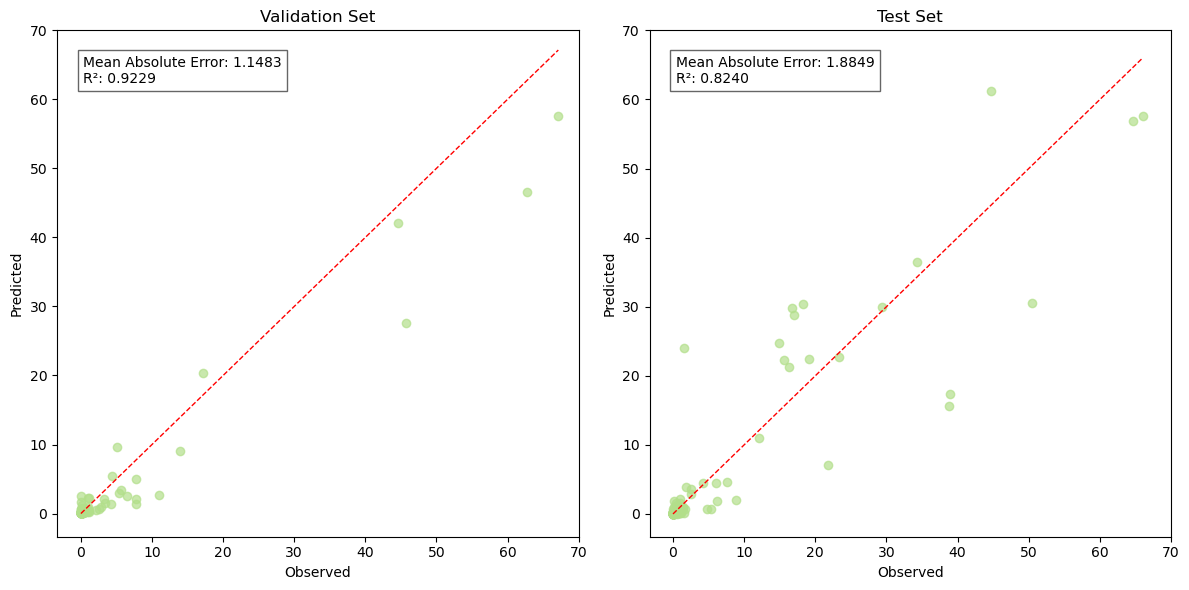

In [119]:
plot_observed_vs_predicted(y_val, y_pred_val, y_test, y_pred_test,scatter_colors=(colors['LightGBM'],colors['LightGBM']), zoom=70)

In [66]:
sr_model_performance['LightGBM'] = {'train': (y_train, y_pred_train),'validation': (y_val, y_pred_val), 'test': (y_test, y_pred_test)}

#### Model 3 SR - CatBoost

In [67]:
X = df[features]
y = df['Sedimentation Rate (MCM/year)'].clip(0)
orig_capacity = df['Original Built Capacity (MCM)']  # needed later

# Encode categorical features
for c in cat_features:
    X[c] = X[c].astype('int')

# Get unique reservoir IDs
unique_rids = df['GRILSS RID'].unique()

# Split reservoirs into train (80%) and temp (20% for val+test)
train_rids, temp_rids = train_test_split(
    unique_rids, test_size=0.2, random_state=45
)

# Split temp into validation and test (50/50 → 10% each overall)
val_rids, test_rids = train_test_split(
    temp_rids, test_size=0.5, random_state=45
)

# Create boolean masks
train_mask = df['GRILSS RID'].isin(train_rids)
val_mask   = df['GRILSS RID'].isin(val_rids)
test_mask  = df['GRILSS RID'].isin(test_rids)

# Split data
X_train = X[train_mask]
y_train = y[train_mask]
cap_train = orig_capacity[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]
cap_val = orig_capacity[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]
cap_test = orig_capacity[test_mask]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

weight_train = pd.Series([5 if x > 10 else 1 for x in cap_train], index=cap_train.index)
weight_val  = pd.Series([5 if x > 10 else 1 for x in cap_val], index=cap_val.index)


# ---- Prepare CatBoost Pools ----
train_pool = Pool(
    data=X_train,
    label=y_train,
    weight=weight_train.values,
    cat_features=cat_features
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    weight=weight_val.values,
    cat_features=cat_features
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)

# ---- Initialize CatBoost Regressor ----
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.12,
    depth=6,
    objective='Huber:delta=12.0',
    l2_leaf_reg=8,
    random_seed=42,
    eval_metric='MAE',
    verbose=100
)

# ---- Train ----
model.fit(
    train_pool,
    eval_set=val_pool,
    early_stopping_rounds=100,
    use_best_model=True
)

# ---- Predict & inverse transform ----
y_pred_train = model.predict(train_pool)
y_pred_val   = model.predict(val_pool)
y_pred_test  = model.predict(test_pool)

y_pred_train = np.clip(y_pred_train, 0, None)
y_pred_val   = np.clip(y_pred_val, 0, None)
y_pred_test  = np.clip(y_pred_test, 0, None)

# ---- Metrics ----
def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("\nSedimentation Rate Performance (CatBoost Tweedie):")
print_metrics("Train", y_train, y_pred_train)
print_metrics("Validation", y_val, y_pred_val)
print_metrics("Test", y_test, y_pred_test)

/tmp/ipykernel_628064/2098781812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('int')
/tmp/ipykernel_628064/2098781812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('int')


Train: (1076, 88) Validation: (106, 88) Test: (133, 88)
0:	learn: 5.7248444	test: 4.0015116	best: 4.0015116 (0)	total: 12.2ms	remaining: 24.3s
100:	learn: 1.9661051	test: 2.2294643	best: 2.2291191 (99)	total: 467ms	remaining: 8.78s
200:	learn: 1.5338490	test: 1.9113700	best: 1.9113700 (200)	total: 889ms	remaining: 7.96s
300:	learn: 1.2602048	test: 1.7147263	best: 1.6834435 (255)	total: 1.4s	remaining: 7.89s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.683443465
bestIteration = 255

Shrink model to first 256 iterations.

Sedimentation Rate Performance (CatBoost Tweedie):
Train RMSE: 3.5849 | MAE: 1.1364 | R²: 0.9436
Validation RMSE: 4.5024 | MAE: 1.3428 | R²: 0.8265
Test RMSE: 4.3943 | MAE: 1.6636 | R²: 0.8628


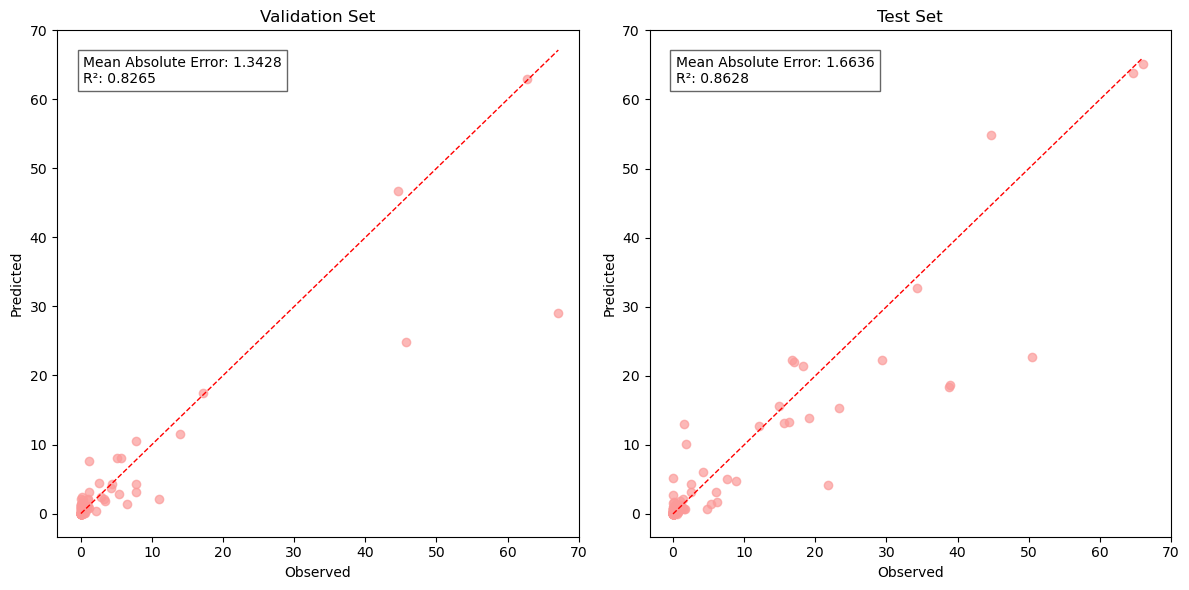

In [149]:
plot_observed_vs_predicted(y_val, y_pred_val, y_test, y_pred_test,scatter_colors=(colors['CatBoost'],colors['CatBoost']), zoom=70)

In [68]:
sr_model_performance['CatBoost'] = {'train': (y_train, y_pred_train),'validation': (y_val, y_pred_val), 'test': (y_test, y_pred_test)}

##### SR Model Comparison

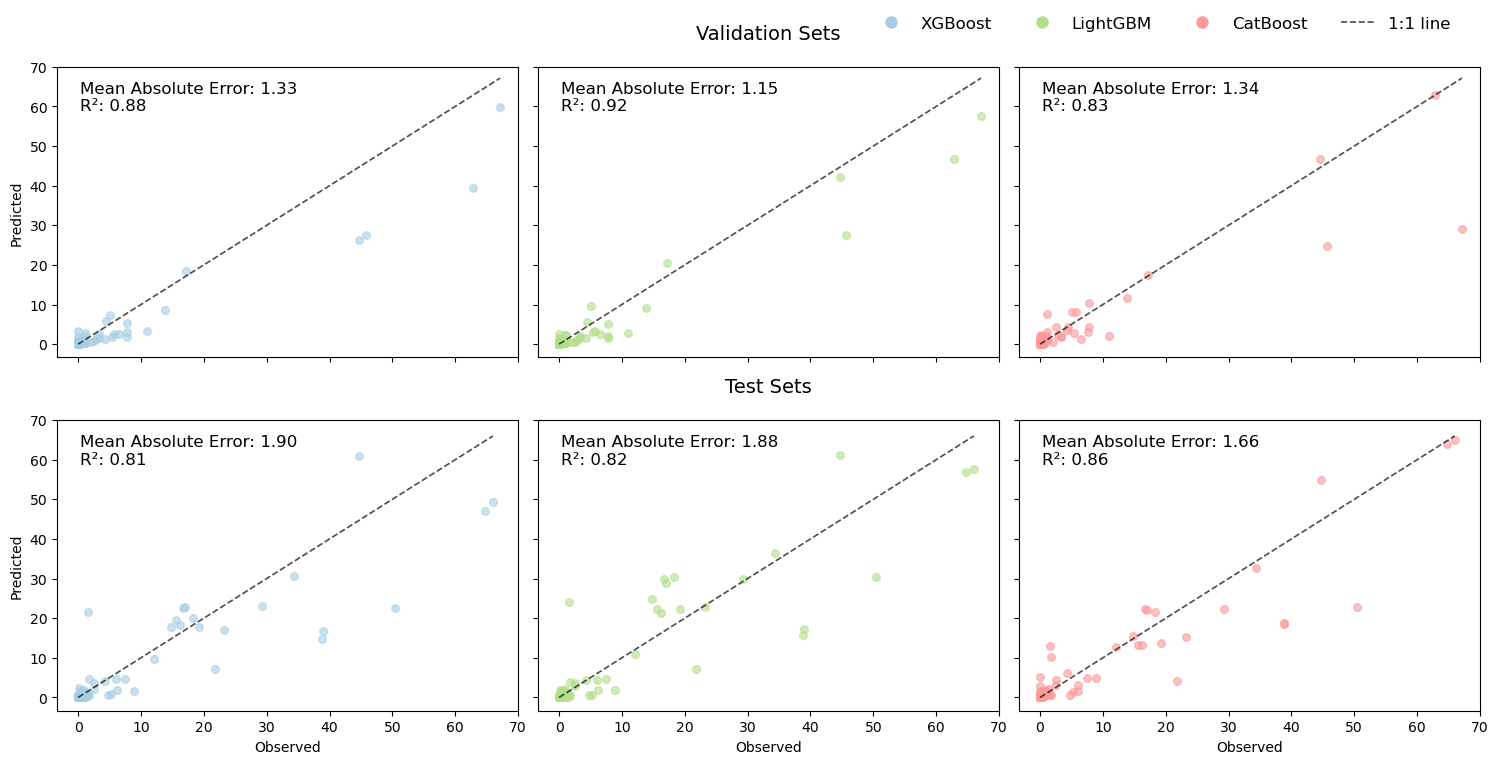

In [151]:
plot_model_comparison_regression(sr_model_performance, colors= {"XGBoost": "#a6cee3", "LightGBM": "#b2df8a", "CatBoost": "#fb9a99"}, zoom =70,
                        savepath = '/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/SR_model_comparison.png')

##### SR Statistics

In [69]:
print("Mean of all sedimentation rates: ", y.mean()) 
print("Variance of all sedimentation rates: ", y.var())
print("Standard Deviation of all sedimentation rates: ", y.std())

Mean of all sedimentation rates:  4.785250343989133
Variance of all sedimentation rates:  210.51833514234085
Standard Deviation of all sedimentation rates:  14.50924998552099


#### RECLAIM: Ensemble Model

In [153]:
def plot_combined_residual_view(sr_model_performance, split='validation',
                                window=30, colors=None, logx=False, zoom=None, savepath=None):
    """
    Two-panel view combining residual bias, error magnitude, and winner shading.

    Residual lines = rolling mean of residuals (observed - predicted) → shows bias.
    Shaded regions = model with lowest absolute error, colored by model, respecting residual sign.

    Parameters
    ----------
    sr_model_performance : dict
        {model: {split: (y_true, y_pred)}}
    split : str or list
        'validation', 'test', or list of splits (e.g., ['train','validation'])
    window : int
        Window size for rolling weighted mean smoothing.
    colors : dict
        Optional, model->color mapping.
    logx : bool
        Whether to use log scale for x-axis.
    zoom : float
        If given, right subplot shows [0, zoom] region.
    savepath : str
        If given, save figure to path.
    """

    models = list(sr_model_performance.keys())
    if colors is None:
        palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = {m: palette[i % len(palette)] for i, m in enumerate(models)}

    fig, axes = plt.subplots(1, 2 if zoom else 1,
                             figsize=(11 if zoom else 10, 5), sharey=True)
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    rolling_data = {}
    x_min, x_max = np.inf, -np.inf

    def weighted_roll_mean(x, w, window):
        res = []
        for i in range(len(x)):
            lo = max(0, i - window // 2)
            hi = min(len(x), i + window // 2 + 1)
            vals = x[lo:hi]
            ww = w[lo:hi]
            if ww.sum() > 0:
                res.append(np.average(vals, weights=ww))
            else:
                res.append(np.nan)
        return np.array(res)

    for m in models:
        # Handle multiple splits
        if isinstance(split, list):
            y_true, y_pred, weights = [], [], []
            total_n = sum(len(sr_model_performance[m][s][0]) for s in split)
            for s in split:
                yt, yp = sr_model_performance[m][s]
                n = len(yt)
                w = n / total_n
                y_true.append(np.array(yt))
                y_pred.append(np.array(yp))
                weights.append(np.full(n, w))
            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)
            weights = np.concatenate(weights)
        else:
            y_true, y_pred = sr_model_performance[m][split]
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            weights = np.ones_like(y_true)

        residuals = y_true - y_pred
        abs_res = residuals

        df_temp = pd.DataFrame({
            "y_true": y_true,
            "residuals": residuals,
            "abs_res": abs_res,
            "weights": weights
        }).sort_values("y_true")

        roll_resid = weighted_roll_mean(df_temp["residuals"].values,
                                        df_temp["weights"].values, window)
        roll_abs = weighted_roll_mean(df_temp["abs_res"].values,
                                      df_temp["weights"].values, window)

        for ax in axes:
            ax.plot(df_temp["y_true"], roll_resid,
                    color=colors[m], lw=2, label=f"{m} bias", alpha=0.9)

        rolling_data[m] = (df_temp["y_true"].values, roll_abs)
        x_min = min(x_min, df_temp["y_true"].min())
        x_max = max(x_max, df_temp["y_true"].max())

    # Interpolate residuals for plotting
    x_grid = np.linspace(x_min, x_max, 500)
    resid_matrix = []
    for m in models:
        xs, roll_resid = rolling_data[m]
        df = pd.DataFrame({"x": xs, "y": roll_resid}).dropna().groupby("x").mean().reset_index()
        resid_interp = np.interp(x_grid, df["x"], df["y"])
        resid_matrix.append(resid_interp)
    resid_matrix = np.vstack(resid_matrix)

    # Determine best model for shading by absolute error only
    abs_matrix = np.abs(resid_matrix)
    winner_idx = np.nanargmin(abs_matrix, axis=0)

    # Shade according to residual sign, but color by model with minimal abs error
    for i, m in enumerate(models):
        mask = winner_idx == i
        if mask.any():
            for ax in axes:
                ax.fill_between(x_grid, 0, resid_matrix[i], where=mask,
                                facecolor=colors[m], alpha=0.35)
    # formatting
    for ax in axes:
        ax.axhline(0, color="k", linestyle="--", lw=1)
        
        if logx:
            ax.set_xscale("log")
        ax.grid(alpha=0.3)

    if zoom and len(axes) == 2:
        axes[0].set_xlim(xmin=0, xmax=zoom)
        axes[0].set_title(f"Sedimentation Rate < {zoom} (MCM/year)")
        axes[1].set_title(f"Sedimentation Rate ≥ {zoom} (MCM/year)")

        axes[0].set_ylabel("Residual (Observed - Predicted)")
        axes[1].set_xlabel("Observed Sedimentation Rate (MCM/year)", x=-0.1)
        # For axes[0] → ensure zoom tick is added at the end
        ticks0 = list(axes[0].get_xticks())
        if zoom not in ticks0:
            ticks0.append(zoom)
        axes[0].set_xticks(ticks0)
        
        # For axes[1] → ensure zoom tick is added at the start
        ticks1 = list(axes[1].get_xticks())
        if zoom not in ticks1:
            ticks1.insert(0, zoom)
        axes[1].set_xticks(ticks1)
        axes[1].set_xlim(xmin=zoom)
        axes[0].set_xlim(xmin=0, xmax=zoom)
    else:
        plt.xlabel("Observed Sedimentation Rate (MCM/year)")
        plt.ylabel("Residual (Observed - Predicted)")
        
    # legend
    line_handles = [plt.Line2D([0], [0], color=colors[m], lw=2) for m in models]
    line_labels = [f"{m} bias (rolling mean residual)" for m in models]
    shade_patch = plt.Rectangle((0, 0), 1, 1, facecolor="gray", alpha=0.35)
    shade_label = "Shaded = Best performing model (lowest abs bias)"
    fig.legend(line_handles + [shade_patch],
               line_labels + [shade_label],
               loc="upper left", frameon=False, fontsize=10, bbox_to_anchor=(0.07, 0.92))

    plt.tight_layout()
    plt.savefig(savepath, dpi=300)
    plt.show()

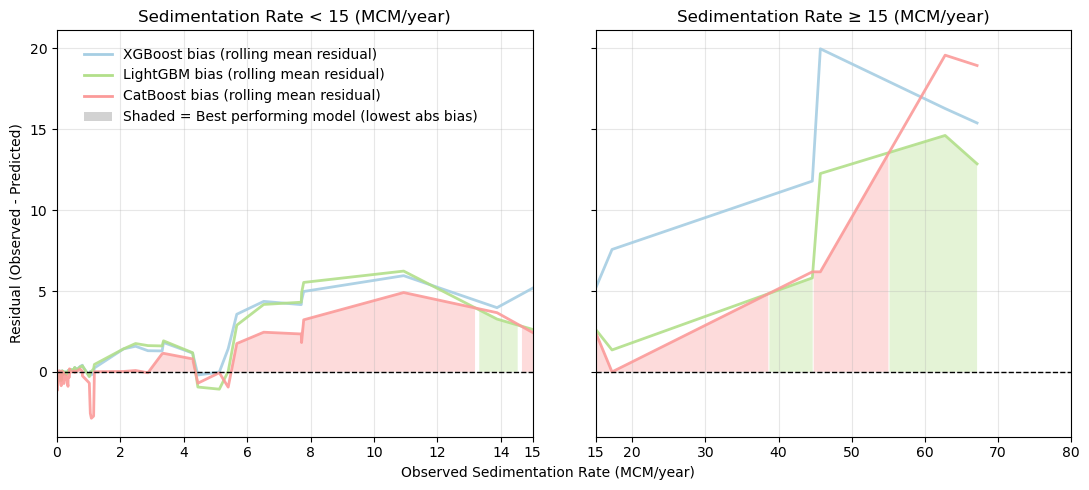

In [154]:
plot_combined_residual_view(sr_model_performance, colors = colors, window=3, split=['validation'],zoom=15,
                            savepath = '/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/SR_model_bias_comparison.png')

In [89]:
class Reclaim:
    """
    A stacked ensemble predictor for Sedimentation Rate (SR) combining
    XGBoost, LightGBM, and CatBoost base models with a meta-model.

    Parameters
    ----------
    model : string, optional
        Any regression model to use for model predictions (default: ensemble of base models). 
        It can be "ensemble", "XGBoost", "LightGBM", or "CatBoost".
    feature_order_list : list, optional
        List of feature names in the order they should be used in the model.
    """
    def __init__(self, model=None, feature_order_list=None):
        self.feature_order_list = feature_order_list
        self.xgb_model = None
        self.lgb_model = None
        self.cat_model = None
        self.main_model = model if model in ['XGBoost', 'LightGBM', 'CatBoost'] else 'ensemble'
        self.cat_features = None
        self.feature_order_list = None

    def fit(self, X_train, y_train, weight_train=None, cat_features=None,
            X_val=None, y_val=None, weight_val=None):
        """
        Train the stacked ensemble model.

        Parameters
        ----------
        X_train : pd.DataFrame or np.array
            Features for training the base models.
        y_train : pd.Series or np.array
            Target variable for training.
        weight_train : pd.Series or np.array, optional
            Sample weights for training base models.
        cat_features : list, optional
            List of categorical feature indices for CatBoost.
        X_val : pd.DataFrame or np.array, optional
            Validation features for early stopping.
        y_val : pd.Series or np.array, optional
            Validation target for early stopping.
        weight_val : pd.Series or np.array, optional
            Validation sample weights.
        """
        self.cat_features = cat_features
        
        if isinstance(X_train, pd.DataFrame):
            # Store the column order
            self.feature_order_list = list(X_train.columns)
        elif isinstance(X_train, np.ndarray):
            if self.feature_order_list is None:
                raise ValueError(
                    "X_train is a NumPy array without column names. "
                    "Please provide 'feature_order_list' explicitly when creating model instance."
                )

        # ---- Train XGBoost ----
        self.xgb_model = xgb.XGBRegressor(
            n_estimators=800,
            learning_rate=0.05,
            tweedie_variance_power=1.5,
            max_depth=5,
            subsample=0.7,
            colsample_bytree=0.7,
            objective='reg:tweedie',
            reg_alpha=70,
            reg_lambda=30,
            # objective='reg:squaredlogerror',  # robust for skewed targets
            random_state=42,
            n_jobs=-1
        )
        self.xgb_model.fit(
            X_train, y_train,
            sample_weight=weight_train,
            eval_set=[(X_val, y_val)] if X_val is not None else None,
            sample_weight_eval_set=[weight_val] if weight_val is not None else None,
            verbose=False
        )

        # ---- Train LightGBM ----
        train_data = lgb.Dataset(X_train, label=y_train, weight=weight_train)
        val_data = lgb.Dataset(X_val, label=y_val, weight=weight_val, reference=train_data) if X_val is not None else None
        self.lgb_model = lgb.train(
            {
                'objective': 'tweedie',
                'tweedie_variance_power': 1.7,
                'metric': 'rmse',
                'learning_rate': 0.01,
                'num_leaves': 31,
                'feature_fraction': 0.7,
                'bagging_fraction': 0.7,
                'bagging_freq': 5,
                'seed': 42,
                'verbosity': -1,
                'lambda_l1': 70,
                'lambda_l2': 5,
            },
            train_data,
            num_boost_round=2000,
            valid_sets=[val_data] if val_data is not None else None
        )

        # ---- Train CatBoost ----
        train_pool = Pool(
            data=X_train,
            label=y_train,
            weight=weight_train,
            cat_features=cat_features
        )
        val_pool = Pool(
            data=X_val,
            label=y_val,
            weight=weight_val,
            cat_features=cat_features
        ) if X_val is not None else None

        self.cat_model = CatBoostRegressor(
            iterations=2000,
            learning_rate=0.12,
            depth=6,
            objective='Huber:delta=12.0',
            l2_leaf_reg=8,
            random_seed=42,
            eval_metric='MAE',
            verbose=100
        )
        self.cat_model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=100,
            use_best_model=True
        )


    def predict(self, X, log_transform=True, dynamic_weight=True, threshold=30, sat_point=70, smooth_factor=0.2, return_weights=False):
        """
        Predict using a stacked ensemble with dynamic, instance-wise weights using sigmoid scaling.

        Weighting Rules
        ---------------
        1. Above threshold (CatBoost as reference):
            - CatBoost weight fixed at 0.6
            - XGBoost weight decays sigmoid-shaped from 0.15 → 0.05
            - LightGBM weight grows sigmoid-shaped from 0.25 → 0.35
            - Saturation occurs near `sat_point`
        2. Below threshold:
            - CatBoost weight grows sigmoid-shaped 0.30 → 0.55 near threshold
            - XGBoost weight decays sigmoid-shaped 0.45 → 0.25 farther below threshold
            - LightGBM weight grows sigmoid-shaped 0.25 → 0.30 near threshold

        Sigmoid scaling ensures smooth transitions instead of abrupt linear changes.

        Parameters
        ----------
        X : pd.DataFrame or np.array
            Features for prediction.
        log_transform : bool
            If True, apply log1p to stabilize high-value predictions.
        dynamic_weight : bool
            If True, use instance-wise weights based on CatBoost prediction.
        threshold : float
            Threshold separating low/high predictions.
        sat_point : float
            Point where above-threshold weights saturate (~70).
        smooth_factor : float
            Controls the sharpness of the sigmoid transition.

        Returns
        -------
        np.array
            Blended predictions.
        pd.DataFrame
            Weights used for the three models.
        """
        if isinstance(X, pd.DataFrame):
            if self.feature_order_list is not None:
                # Reorder columns automatically
                X = X[self.feature_order_list]
        elif isinstance(X, np.ndarray):
            warnings.warn(
                    "Predicting with NumPy array: assumes column order matches training order. "
                    "Safer to use DataFrame with feature names."
                )
            
            
        # Base model predictions
        pred_xgb = self.xgb_model.predict(X)
        pred_lgb = self.lgb_model.predict(X)
        pred_cat = self.cat_model.predict(X)
        
        if self.main_model == 'ensemble':

            # Log-space transform if needed
            if log_transform:
                pred_xgb = np.log1p(pred_xgb)
                pred_lgb = np.log1p(pred_lgb)
                pred_cat = np.log1p(pred_cat)
                threshold = np.log1p(threshold)
                sat_point = np.log1p(sat_point)

            if dynamic_weight:
                blended_preds = []
                weights = []

                for px, pl, pc in zip(pred_xgb, pred_lgb, pred_cat):
                    if pc >= threshold:
                        # Above threshold: sigmoid scales XGB/LGB weights from threshold → sat_point
                        sig = 1 / (1 + np.exp(-smooth_factor * (pc - threshold)))  # sigmoid at current pc
                        sig_sat = 1 / (1 + np.exp(-smooth_factor * (sat_point - threshold)))  # sigmoid at saturation
                        factor = (sig - 0.5) / (sig_sat - 0.5)  # scale so 0 → threshold, 1 → sat_point
                        factor = np.clip(factor, 0, 1)

                        w_cat = 0.6
                        w_xgb = 0.15 - 0.10 * factor  # decays 0.15 → 0.05
                        w_lgb = 0.25 + 0.10 * factor  # grows 0.25 → 0.35

                    else:
                        # Below threshold: sigmoid scales weights from 0 → threshold
                        sig = 1 / (1 + np.exp(-smooth_factor * (pc)))       # raw sigmoid
                        sig_min = 1 / (1 + np.exp(-smooth_factor * 0))      # sigmoid at 0
                        sig_max = 1 / (1 + np.exp(-smooth_factor * threshold))  # sigmoid at threshold
                        sig_scaled = (sig - sig_min) / (sig_max - sig_min)  # scale 0 → 1
                        sig_scaled = np.clip(sig_scaled, 0, 1)

                        w_cat = 0.30 + 0.25 * sig_scaled   # grows 0.30 → 0.55
                        w_xgb = 0.45 - 0.20 * sig_scaled   # decays 0.45 → 0.25
                        w_lgb = 0.25 + 0.05 * sig_scaled   # grows 0.25 → 0.30

                    # Normalize weights
                    total = w_cat + w_xgb + w_lgb
                    w_cat, w_xgb, w_lgb = w_cat/total, w_xgb/total, w_lgb/total
                    weights.append([w_xgb, w_lgb, w_cat])
                    
                    # Weighted prediction
                    blended_preds.append(w_cat * pc + w_xgb * px + w_lgb * pl)
                
                weight_df = pd.DataFrame(weights, columns=['XGBoost','LightGBM','CatBoost'])
                pred_blend = np.array(blended_preds)

            else:
                # Simple average
                pred_blend = (pred_xgb + pred_lgb + pred_cat) / 3

            # Convert back from log-space if applied
            if log_transform:
                pred_blend = np.expm1(pred_blend)
            
            if return_weights:
                return (pred_blend,weight_df)
            else:
                return pred_blend
        
        elif self.main_model == 'XGBoost':
            return pred_xgb
        elif self.main_model == 'LightGBM':
            return pred_lgb
        elif self.main_model == 'CatBoost':
            return pred_cat
        else:
            return None
            

    def evaluate(self, X, y_true):
        """
        Evaluate the ensemble model on a dataset.

        Parameters
        ----------
        X : pd.DataFrame or np.array
            Features for evaluation.
        y_true : pd.Series or np.array
            True target values.

        Returns
        -------
        dict
            Dictionary containing RMSE, MAE, and R2 metrics.
        """
        preds = self.predict(X)
        rmse = root_mean_squared_error(y_true, preds)
        mae = mean_absolute_error(y_true, preds)
        r2 = r2_score(y_true, preds)
        return {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    def eval_metrics(self, y_true, y_pred):
        rmse = root_mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    def _extract_importance(self, model, model_name):
        """Helper to get importance + feature names for any base model."""
        if model is None:
            raise ValueError(f"{model_name} model is not trained or assigned.")

        if model_name == "xgb":
            # XGBoost can be sklearn wrapper or Booster
            try:
                imp = model.feature_importances_
                names = getattr(model, "feature_names_in_", np.arange(len(imp)))
            except AttributeError:
                imp_dict = model.get_score(importance_type="weight")
                names, imp = zip(*imp_dict.items())
                imp = np.array(imp)
        elif model_name == "lgb":
            try:
                imp = model.feature_importance(importance_type="split")
                names = model.feature_name()
            except AttributeError:
                imp = model.feature_importances_
                names = getattr(model, "feature_names_in_", np.arange(len(imp)))
        elif model_name == "cat":
            try:
                imp = model.get_feature_importance()
                names = model.feature_names_
            except AttributeError:
                imp = model.feature_importances_
                names = getattr(model, "feature_names_in_", np.arange(len(imp)))
        else:
            raise ValueError(f"Unknown model name {model_name}")

        return np.array(imp, dtype=float), np.array(names)

    def get_feature_importance(self, model_name: str = "average", normalize: bool = True, percentage: bool = False, weights=None):
        """
        Get feature importance from base models or their weighted average.

        Parameters
        ----------
        model_name : str, default="average"
            - "average": return importance across all models (with weighted average column)
            - "xgb", "lgb", "cat": return importance from that specific model
        normalize : bool, default=True
            Whether to normalize importances so they sum to 1 for each model
            (before averaging in case of "average").
        percentage : bool, default=False
            Whether to scale importances to percentages (0–100).
            - For "average": returns DataFrame with each model + weighted average.
            - For single model: returns Series.
        weights : list of float or None, default=None
            Weights for ["xgb", "lgb", "cat"] when computing the average.
            - If None, defaults to equal weights for available models.
            - Length must equal the number of models used.

        Returns
        -------
        pd.DataFrame or pd.Series
            - If model_name="average": DataFrame with each model + weighted average.
            - If specific model: Series with feature importances.
        """
        models = {
            "xgb": self.xgb_model,
            "lgb": self.lgb_model,
            "cat": self.cat_model
        }

        if model_name == "average":
            df_list = []
            available_models = []
            for name, model in models.items():
                if model is None:
                    continue
                imp, names = self._extract_importance(model, name)
                imp_series = pd.Series(imp, index=names)

                if normalize or percentage:
                    imp_series = imp_series / imp_series.sum()
                if percentage:
                    imp_series = imp_series * 100

                df = pd.DataFrame({name: imp_series})
                df_list.append(df)
                available_models.append(name)

            if not df_list:
                raise ValueError("No fitted models found with feature importance.")

            # Merge on feature names
            all_importances = pd.concat(df_list, axis=1).fillna(0)

            # Handle weights
            if weights is None:
                weights = [1.0] * len(available_models)
            if len(weights) != len(available_models):
                raise ValueError(f"Length of weights ({len(weights)}) does not match number of available models ({len(available_models)}).")

            weights = np.array(weights, dtype=float)
            weights = weights / weights.sum()  # normalize weights to sum = 1

            # Compute weighted average
            all_importances["average"] = (all_importances[available_models] * weights).sum(axis=1)

            # Sort by average importance
            all_importances = all_importances.sort_values("average", ascending=False)

            return all_importances

        else:
            if model_name not in models:
                raise ValueError(f"Invalid model_name '{model_name}'. Choose from 'xgb', 'lgb', 'cat', or 'average'.")
            model = models[model_name]
            if model is None:
                raise ValueError(f"{model_name} model is not trained or assigned.")
            imp, names = self._extract_importance(model, model_name)
            imp_series = pd.Series(imp, index=names, name=f"{model_name}_importance").sort_values(ascending=False)

            if normalize or percentage:
                imp_series = imp_series / imp_series.sum()
            if percentage:
                imp_series = imp_series * 100

            return imp_series
    def save_model(self, save_dir: str = "models", prefix: str = "v1"):
        """
        Save trained models (XGBoost, LightGBM, CatBoost) and metadata.

        Parameters
        ----------
        save_dir : str, default="models"
            Directory to save the models.
        prefix : str, default="v1"
            Prefix for filenames.
        """
        os.makedirs(save_dir, exist_ok=True)

        # Save XGBoost
        if self.xgb_model is not None:
            self.xgb_model.save_model(os.path.join(save_dir, f"{prefix}_xgb.json"))

        # Save LightGBM
        if self.lgb_model is not None:
            self.lgb_model.save_model(os.path.join(save_dir, f"{prefix}_lgb.txt"))

        # Save CatBoost
        if self.cat_model is not None:
            self.cat_model.save_model(os.path.join(save_dir, f"{prefix}_cat.cbm"))

        # Save metadata (like which model is primary, cat_features)
        metadata = {
            "main_model": self.main_model,
            "cat_features": self.cat_features,
            "feature_order_list": self.feature_order_list
        }
        joblib.dump(metadata, os.path.join(save_dir, f"{prefix}_meta.pkl"))

        print(f"Models saved successfully in '{save_dir}'")

    def load_model(self, load_dir: str = None, prefix: str = "reclaim"):
        """
        Load trained models (XGBoost, LightGBM, CatBoost) and metadata.

        Parameters
        ----------
        load_dir : str, optional
            Directory where models are stored.
            If None, defaults to the installed package's `pretrained_model` folder.
        prefix : str, default="reclaim"
            Prefix for filenames.
        """
        if load_dir is None:
            # Default: look inside the package directory
            package_dir = os.path.dirname(__file__)  # folder of this file
            load_dir = os.path.join(package_dir, "pretrained_model")

        # Load XGBoost
        xgb_path = os.path.join(load_dir, f"{prefix}_xgb.json")
        if os.path.exists(xgb_path):
            import xgboost as xgb
            self.xgb_model = xgb.XGBRegressor()
            self.xgb_model.load_model(xgb_path)

        # Load LightGBM
        lgb_path = os.path.join(load_dir, f"{prefix}_lgb.txt")
        if os.path.exists(lgb_path):
            import lightgbm as lgb
            self.lgb_model = lgb.Booster(model_file=lgb_path)

        # Load CatBoost
        cat_path = os.path.join(load_dir, f"{prefix}_cat.cbm")
        if os.path.exists(cat_path):
            from catboost import CatBoostRegressor
            self.cat_model = CatBoostRegressor()
            self.cat_model.load_model(cat_path)

        # Load metadata
        meta_path = os.path.join(load_dir, f"{prefix}_meta.pkl")
        if os.path.exists(meta_path):
            metadata = joblib.load(meta_path)
            self.main_model = metadata.get("main_model", "ensemble")
            self.cat_features = metadata.get("cat_features", None)
            self.feature_order_list = metadata.get("feature_order_list", None)

        print(f"Models loaded successfully from '{load_dir}'")

In [109]:
df_shorthand.to_csv('/tiger1/msanchit/research/sedimentation/RECLAIM data/model_training_data/RECLAIM_model_development_data.csv', index=False)

In [ ]:
# For later usage of this model, we will make use of shorthand_df and shorthand column headers. 

X = df_shorthand[shorthand_features].copy()
y = df_shorthand['Sedimentation Rate (MCM/year)'].clip(0)
orig_capacity = df_shorthand['Original Built Capacity (MCM)']  # needed later

# Encode categorical features
for c in shorthand_cat_features:
    X[c] = X[c].astype("Int64")

# Get unique reservoir IDs
unique_rids = df_shorthand['GRILSS RID'].unique()

# Split reservoirs into train (80%) and temp (20% for val+test)
train_rids, temp_rids = train_test_split(
    unique_rids, test_size=0.2, random_state=45
)

# Split temp into validation and test (50/50 → 10% each overall)
val_rids, test_rids = train_test_split(
    temp_rids, test_size=0.5, random_state=45
)

# Create boolean masks
train_mask = df_shorthand['GRILSS RID'].isin(train_rids)
val_mask   = df_shorthand['GRILSS RID'].isin(val_rids)
test_mask  = df_shorthand['GRILSS RID'].isin(test_rids)

# Split data
X_train = X[train_mask]
y_train = y[train_mask]
cap_train = orig_capacity[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]
cap_val = orig_capacity[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]
cap_test = orig_capacity[test_mask]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

weight_train = pd.Series([5 if x > 10 else 1 for x in cap_train], index=cap_train.index)
weight_val  = pd.Series([5 if x > 10 else 1 for x in cap_val], index=cap_val.index)

## Training model
ensemble = Reclaim()
ensemble.fit(X_train, y_train, weight_train=weight_train.values, cat_features=shorthand_cat_features,
             X_val=X_val, y_val=y_val, weight_val=weight_val.values)


Train: (1076, 88) Validation: (106, 88) Test: (133, 88)
0:	learn: 5.7248444	test: 4.0015116	best: 4.0015116 (0)	total: 6ms	remaining: 12s
100:	learn: 1.9661051	test: 2.2294643	best: 2.2291191 (99)	total: 496ms	remaining: 9.32s
200:	learn: 1.5338490	test: 1.9113700	best: 1.9113700 (200)	total: 987ms	remaining: 8.84s
300:	learn: 1.2602048	test: 1.7147263	best: 1.6834435 (255)	total: 1.5s	remaining: 8.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.683443465
bestIteration = 255

Shrink model to first 256 iterations.


In [ ]:
## Predicting from trained model
preds_test = ensemble.predict(
    X_test,
    log_transform=False,
    dynamic_weight=True,
    threshold=15,
    smooth_factor=0.7
)

metrics = ensemble.eval_metrics(y_test,preds_test)
print('Test set:', metrics)

preds_val = ensemble.predict(
    X_val,
    log_transform=False,
    dynamic_weight=True,
    threshold=15,
    smooth_factor=0.7
)

metrics = ensemble.eval_metrics(y_val,preds_val)
print('Validation set:', metrics)

preds_train, reclaim_weights_train = ensemble.predict(
    X_train,
    log_transform=False,
    dynamic_weight=True,
    threshold=15,    
    smooth_factor=0.7,
    return_weights=True
)

metrics = ensemble.eval_metrics(y_train,preds_train)
print('Train set:', metrics)

Test set: {'RMSE': 4.442267219645034, 'MAE': 1.6494685800728448, 'R2': 0.8598010633527048}
Validation set: {'RMSE': 3.574161896511849, 'MAE': 1.1535205455009834, 'R2': 0.8906949411107421}
Train set: {'RMSE': 3.4540644519653814, 'MAE': 1.002885352060549, 'R2': 0.947655790674147}


In [ ]:
## Save Model
ensemble.save_model(save_dir='/tiger1/msanchit/research/sedimentation/codes/RECLAIM/src/reclaim/pretrained_model',
                    prefix='reclaim')

Models saved successfully in '/tiger1/msanchit/research/sedimentation/codes/RECLAIM/src/reclaim/pretrained_model'


In [ ]:
## Load into a new Model
ens = Reclaim()
ens.load_model(load_dir='/tiger1/msanchit/research/sedimentation/codes/RECLAIM/src/reclaim/pretrained_model',
               prefix='reclaim')

Models loaded successfully from '/tiger1/msanchit/research/sedimentation/codes/RECLAIM/src/reclaim/pretrained_model'


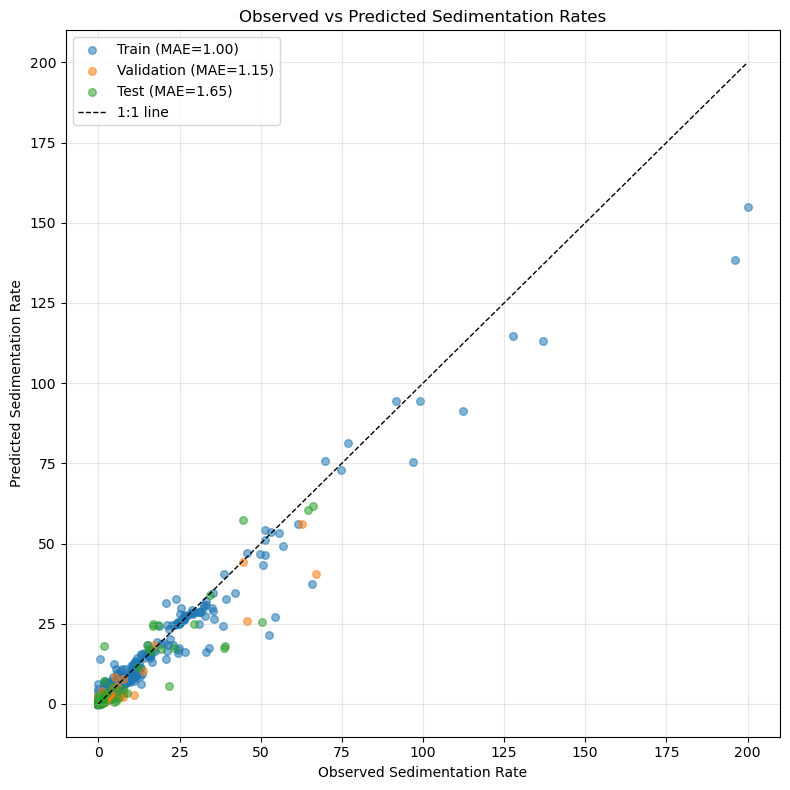

In [ ]:
## Performance figure
# Collect predictions and true values in a dictionary
datasets = {
    "Train": (y_train, preds_train, "#1f77b4"),       # blue
    "Validation": (y_val, preds_val, "#ff7f0e"),     # orange
    "Test": (y_test, preds_test, "#2ca02c"),         # green
}

plt.figure(figsize=(8, 8))

for name, (y_true, y_pred, color) in datasets.items():
    mae = mean_absolute_error(y_true, y_pred)
    plt.scatter(y_true, y_pred, s=30, alpha=0.55, label=f"{name} (MAE={mae:.2f})", color=color)

# Plot 1:1 line
min_val = min(min(y_train), min(y_val), min(y_test))
max_val = max(max(y_train), max(y_val), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label="1:1 line")

plt.xlabel("Observed Sedimentation Rate")
plt.ylabel("Predicted Sedimentation Rate")
plt.title("Observed vs Predicted Sedimentation Rates")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/RECLAIM_Performance.png", dpi=300)
plt.show()

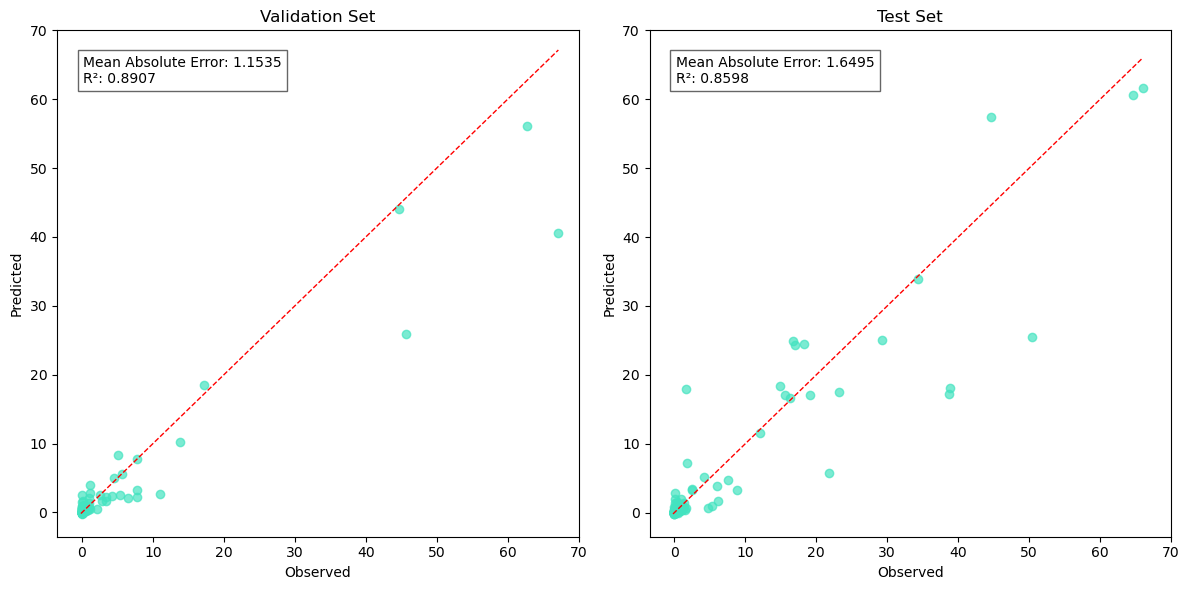

In [166]:
plot_observed_vs_predicted(y_val, preds_val, y_test, preds_test,scatter_colors=("#43e3c0ef","#43e3c0ef"), zoom=70)

#### Feature Importance CLR

In [185]:
def extract_importance(model, model_name):
    """Extract feature importance + feature names for XGB, LGBM, CatBoost."""
    
    if model_name.lower() in ["xgb", "xgboost"]:
        # XGBoost (sklearn wrapper or Booster)
        imp = model.feature_importances_
        names = getattr(model, "feature_names_in_", np.arange(len(imp)))
    elif model_name.lower() in ["lgb", "lightgbm"]:
        # LightGBM
        imp = model.feature_importance(importance_type="split")
        names = model.feature_name()
    elif model_name.lower() in ["cat", "catboost"]:
        # CatBoost
        imp = model.get_feature_importance()
        names = model.feature_names_
    
    else:
        raise ValueError(f"Unknown model name {model_name}")
    
    return np.array(imp, dtype=float), np.array(names)


# --- Collect for all models ---
importance_dict = {}
for model_name, model in clr_models.items():
    imp, names = extract_importance(model, model_name)
    importance_dict[model_name] = pd.Series(imp, index=names)

# --- Combine into DataFrame ---
clr_fi_df = pd.DataFrame(importance_dict)

# Normalize per model (column) to percentage
clr_fi_df = clr_fi_df.div(clr_fi_df.sum(axis=0), axis=1) * 100

# Add average column
clr_fi_df["Average"] = clr_fi_df.mean(axis=1)

# Sort by mean
clr_fi_df = clr_fi_df.sort_values("Average", ascending=False)

clr_fi_df.head()

,XGBoost,LightGBM,CatBoost,Average
log_original_cap,1.540248,1.446023,27.643275,10.209849
aspect_mean,25.640446,2.368487,1.350332,9.786422
relative_original_capacity,2.531797,2.322779,11.043777,5.299451
dominant_class_mode,14.595753,0.074794,0.115025,4.928524
age_at_observation_end,1.507330,2.655198,9.952537,4.705022


#### Feature Importance SR

In [96]:
reclaim_weights_train.mean(axis=0)

XGBoost     0.349489
LightGBM    0.264661
CatBoost    0.385850
dtype: float64

In [97]:
sr_fi_df = ensemble.get_feature_importance(normalize=True, percentage=True, weights=[0.35,0.26,0.39])

In [98]:
sr_fi_df.head()

,xgb,lgb,cat,average
log_OBC,25.580140,4.350861,11.665666,14.633882
log_LCWB,18.123307,1.081899,3.537828,8.004204
log_SA_mean_clip,0.288825,0.331550,18.451148,7.383239
log_CA,12.262684,0.360633,5.650691,6.589474
log_LCM,5.976027,0.122150,5.622995,4.316336


In [107]:
col = "average"
temp_df = pd.DataFrame()
temp_df['Feature Importance (%)'] = sr_fi_df[col].sort_values(ascending=False)
temp_df['Cumulative Importance (%)'] = temp_df['Feature Importance (%)'].cumsum() 
temp_df

,Feature Importance (%),Cumulative Importance (%)
log_OBC,14.633882,14.633882
log_LCWB,8.004204,22.638086
log_SA_mean_clip,7.383239,30.021326
log_CA,6.589474,36.610800
log_LCM,4.316336,40.927136
log_LCG,3.379634,44.306770
log_LCSG,2.390016,46.696786
log_SA_std,1.985361,48.682147
wind_mean,1.840513,50.522661
log_rain_per_area,1.765137,52.287797


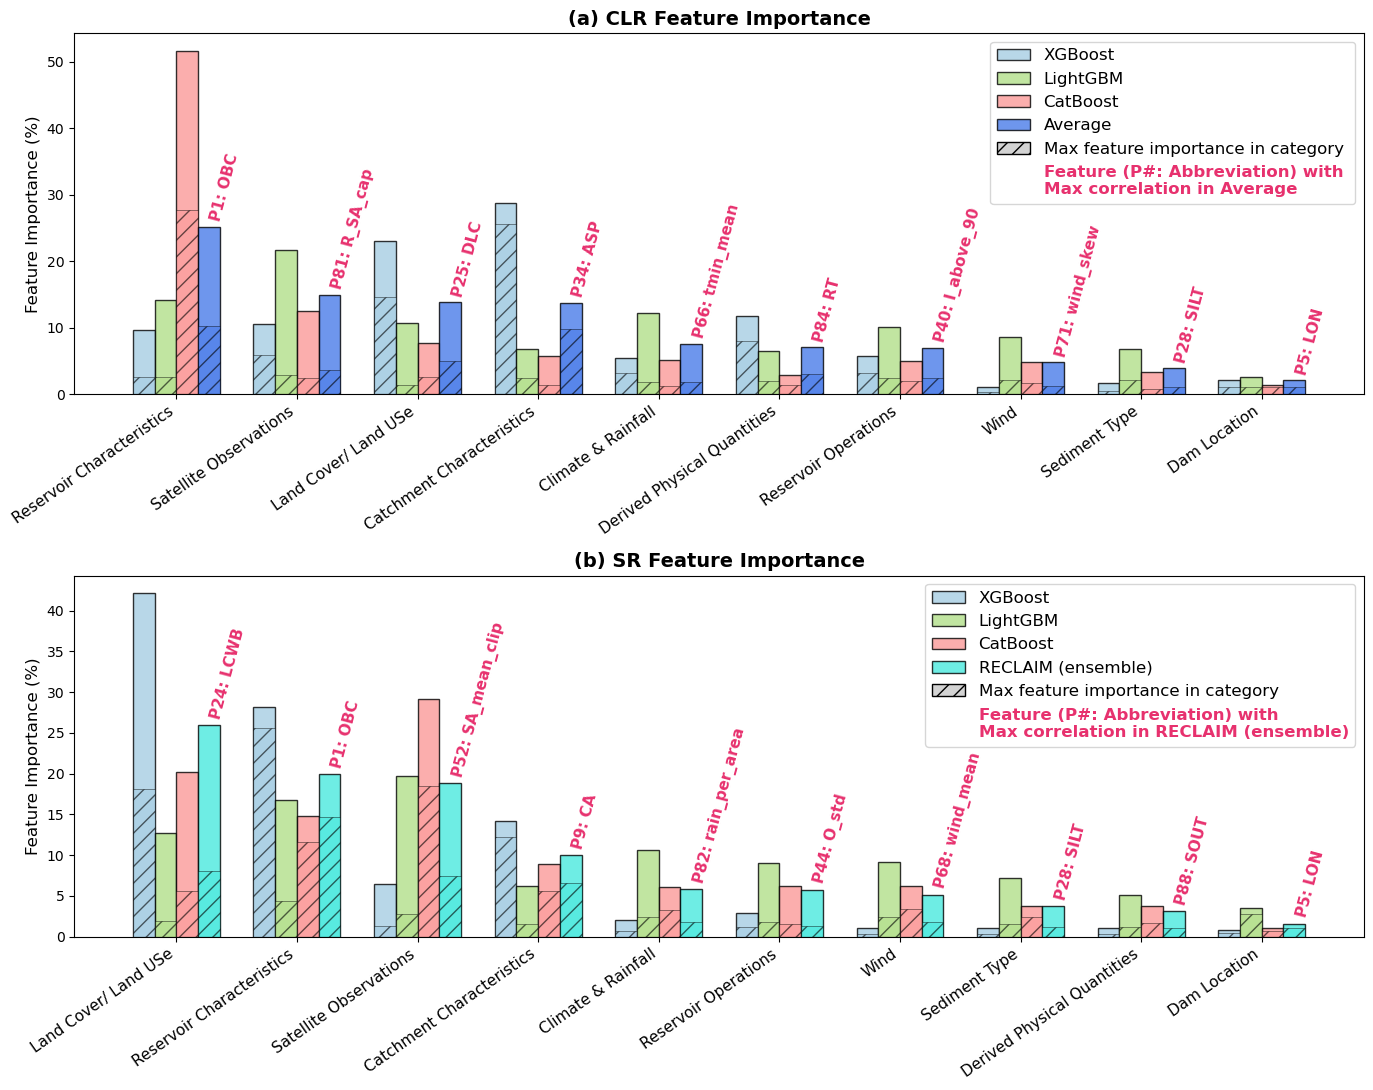

In [195]:
# --- Step 0: Settings ---
color_palette_FI = {"xgb": "#a6cee3","XGBoost":"#a6cee3", "lgb": "#b2df8a", "LightGBM":"#b2df8a", "cat": "#fb9a99",
                    "CatBoost":"#fb9a99",'average': "#4ae9deee", 'RECLAIM': '#4ae9deee', "Average":"#4a7ce9ed"}

# Mapping display names
full_model_name_sr = {"xgb": "XGBoost", "lgb": "LightGBM", "cat": "CatBoost", "average": "RECLAIM (ensemble)"}
full_model_name_clr = {"XGBoost": "XGBoost", "LightGBM": "LightGBM", "CatBoost": "CatBoost", "Average": "Average"}

fig, axes = plt.subplots(2, 1, figsize=(14, 11))

for ax, fi_df, title, label_letter, full_model_name in zip(
        axes,
        [clr_fi_df, sr_fi_df],
        ["CLR Feature Importance", "SR Feature Importance"],
        ["(a)", "(b)"],
        [full_model_name_clr, full_model_name_sr]):

    # Map features to category
    category_map = {}
    for cat, feats in feature_categories.items():
        for f in feats:
            category_map[f] = cat

    fi_category = fi_df.copy()
    fi_category['Category'] = [category_map[f] for f in fi_df.index]

    # Aggregate sum & max per category
    fi_agg = fi_category.groupby('Category').agg(['sum','max'])

    # Sort categories by descending average importance
    avg_col = 'average' if 'average' in fi_df.columns else 'Average'
    fi_agg = fi_agg.sort_values(by=(avg_col,'sum'), ascending=False)
    categories = fi_agg.index

    models = [c for c in fi_df.columns if c != 'Category']
    x = np.arange(len(categories))
    bar_width = 0.18

    # Plot bars and annotate top feature per sum bar
    for i, model in enumerate(models):
        # Sum bars (total importance)
        bars = ax.bar(x + i*bar_width, fi_agg[(model,'sum')],
                      width=bar_width,
                      facecolor=color_palette_FI.get(model,'#888888'),
                      edgecolor='black',
                      alpha=0.8,
                      label=f"{full_model_name.get(model,model)}")

        # Max overlay (hatched)
        ax.bar(x + i*bar_width, fi_agg[(model,'max')],
               width=bar_width,
               facecolor=color_palette_FI.get(model,'#888888'),
               edgecolor='black',
               hatch="//",
               linewidth=0.5,
               alpha=0.6)

        if model == 'average' or model == 'Average':
            # Annotate **top feature per sum bar**
            for j, cat in enumerate(categories):
                feats_in_cat = [f for f in fi_category.index if fi_category.loc[f,'Category']==cat]
                sub = fi_category.loc[feats_in_cat, model]
                max_feat = sub.idxmax()  # feature contributing most to sum
                pos = ordered_features.index(max_feat) + 1
                shorthand = shorthand_features[ordered_features.index(max_feat)]
                y_pos = fi_agg[(model,'sum')][cat] + 0.02 * fi_agg[(model,'sum')].max()  # offset above sum bar
                ax.text(x[j] + i*bar_width, y_pos+ 0.02,
                        f"P{pos}: {shorthand}", ha='left', va='bottom',
                        fontsize=11, rotation=75, color='#e7316e', weight=555)


    # X-axis ticks for categories
    ax.set_xticks(x + bar_width*(len(models)-1)/2)
    ax.set_xticklabels(categories, fontsize=11, rotation=35, ha='right')

    ax.set_ylabel("Feature Importance (%)", fontsize=12)
    ax.set_title(f"{label_letter} {title}", fontsize=14, weight='bold')

    # Legend
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    # Max overlay patch
    max_patch = Patch(facecolor='lightgrey', hatch='//', edgecolor='black',
                      label="Max feature importance in category")
    by_label["Max feature importance in category"] = max_patch
    # Red label explanation
    red_label = Patch(facecolor='none', edgecolor='none', label="P#:Abbreviation = Feature with  max contribution to sum bar")
    by_label[f"Feature (P#: Abbreviation) with \nMax correlation in {full_model_name[models[-1]]}"] = red_label

    legend = ax.legend(by_label.values(), by_label.keys(), fontsize=12)
    legend.get_texts()[-1].set_color("#e7316e")
    legend.get_texts()[-1].set_weight(555)
legend
plt.tight_layout()
plt.savefig('/tiger1/msanchit/research/sedimentation/data_analysis/paper_plots/CLR_SR_feature_importance.png', dpi=300)
plt.show()

#### Top 10 features in CLR and SR models (Ensemble Average)

In [ ]:
sr_fi_df.assign(
    PNumber=[f"P{ordered_features.index(f)+1}" for f in sr_fi_df.index],
    Abbreviation=[shorthand_features[ordered_features.index(f)] for f in sr_fi_df.index]
).head(10)

,xgb,lgb,cat,average,PNumber,Abbreviation
log_original_cap,25.580140,4.350861,11.665666,14.633882,P1,OBC
waterbodies_log_catchment_area,18.123307,1.081899,3.537828,8.004204,P24,LCWB
log_SA_annual_mean_clip,0.288825,0.331550,18.451148,7.383239,P52,SA_mean_clip
log_catchment_area,12.262684,0.360633,5.650691,6.589474,P9,CA
mangroves_log_catchment_area,5.976027,0.122150,5.622995,4.316336,P20,LCM
grassland_log_catchment_area,5.152744,0.744532,3.545116,3.379634,P16,LCG
snow_glaciers_log_catchment_area,4.975100,0.820149,1.116647,2.390016,P23,LCSG
log_SA_annual_std,1.341006,1.052815,3.185326,1.985361,P48,SA_std
wind_annual_mean,0.172309,1.797348,3.366397,1.840513,P68,wind_mean
rainfall_per_unit_area,0.667992,1.000465,3.259535,1.765137,P82,rain_per_area


In [219]:
clr_fi_df.assign(
    PNumber=[f"P{ordered_features.index(f)+1}" for f in clr_fi_df.index],
    Abbreviation=[shorthand_features[ordered_features.index(f)] for f in clr_fi_df.index]
).head(10)

,XGBoost,LightGBM,CatBoost,Average,PNumber,Abbreviation
log_original_cap,1.540248,1.446023,27.643275,10.209849,P1,OBC
aspect_mean,25.640446,2.368487,1.350332,9.786422,P34,ASP
relative_original_capacity,2.531797,2.322779,11.043777,5.299451,P74,ROBC
dominant_class_mode,14.595753,0.074794,0.115025,4.928524,P25,DLC
age_at_observation_end,1.507330,2.655198,9.952537,4.705022,P73,AGE
SA_mean_annual_to_capacity,5.878567,2.954375,1.967564,3.600169,P81,R_SA_cap
residence_time,8.062717,0.660683,0.244768,2.989389,P84,RT
max_days_annual_inflow_above_90,3.113881,2.464057,1.495345,2.357761,P40,I_above_90
tmin_annual_mean,3.138892,1.317211,1.238912,1.898338,P66,tmin_mean
trapping_efficiency,2.795007,1.350453,1.426246,1.857235,P83,TE


#### Tope features with >1% FI in all gradient boosting models

In [220]:
sr_fi_df.assign(
    PNumber=[f"P{ordered_features.index(f)+1}" for f in sr_fi_df.index],
    Abbreviation=[shorthand_features[ordered_features.index(f)] for f in sr_fi_df.index]
)[(sr_fi_df.iloc[:, :3] >= 1).all(axis=1)].head(10)

,xgb,lgb,cat,average,PNumber,Abbreviation
log_original_cap,25.580140,4.350861,11.665666,14.633882,P1,OBC
waterbodies_log_catchment_area,18.123307,1.081899,3.537828,8.004204,P24,LCWB
log_SA_annual_std,1.341006,1.052815,3.185326,1.985361,P48,SA_std
cropland_log_catchment_area,1.642522,1.622848,1.565275,1.607280,P15,LCC
log_mean_annual_outflow_std,1.127022,1.192415,1.503780,1.290960,P43,O_std


In [221]:
clr_fi_df.assign(
    PNumber=[f"P{ordered_features.index(f)+1}" for f in clr_fi_df.index],
    Abbreviation=[shorthand_features[ordered_features.index(f)] for f in clr_fi_df.index]
)[(clr_fi_df.iloc[:, :3] >= 1).all(axis=1)].head(10)

,XGBoost,LightGBM,CatBoost,Average,PNumber,Abbreviation
log_original_cap,1.540248,1.446023,27.643275,10.209849,P1,OBC
aspect_mean,25.640446,2.368487,1.350332,9.786422,P34,ASP
relative_original_capacity,2.531797,2.322779,11.043777,5.299451,P74,ROBC
age_at_observation_end,1.507330,2.655198,9.952537,4.705022,P73,AGE
SA_mean_annual_to_capacity,5.878567,2.954375,1.967564,3.600169,P81,R_SA_cap
max_days_annual_inflow_above_90,3.113881,2.464057,1.495345,2.357761,P40,I_above_90
tmin_annual_mean,3.138892,1.317211,1.238912,1.898338,P66,tmin_mean
trapping_efficiency,2.795007,1.350453,1.426246,1.857235,P83,TE
Longitude,1.092757,1.009723,1.148020,1.083500,P5,LON
